In [1]:
from metabolinks import align, read_aligned_spectra, read_spectra_from_xcel
from metabolinks.similarity import mz_similarity
import pandas as pd
from metabolinks import AlignedSpectra
import numpy as np

### Similarity analysis with Metabolights data: 
#### Wolbachia Modulates Lipid Metabolism in Aedes albopictus Mosquito Cells

Article link: http://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC4959074&blobtype=pdf

Metabolights dataset link: https://www.ebi.ac.uk/metabolights/MTBLS210

Four groups including a quality control and 3 groups of Aedes albopictus Aa23 cells with different amount of replicates (slightly unbalanced data).
- QC - Quality Control samples - 7 samples (one of the datasets had 9, but to compare with each other 2 were left out).
- L_A/LA - Aedes albopictus Aa23 cells with no infection - 7 samples.
- L_AM/LAM - Aedes albopictus Aa23 cells infected with Mel - 6 samples.
- L_AP/LAP - Aedes albopictus Aa23 cells infected with MelPop - 6 samples.

Metabolomics approach:
- Negative-ion-mode direct-infusion (DI) FT-ICR MS was conducted using a hybrid 7-T linear ion trap FT-ICR mass spectrometer 
- Reversed-phase high-performance liquid chromatography (RPLC) FT-ICR MS-based analysis - LC-FT-ICR MS.
- “Replicate filtering,” peaks were retained if they were found in two out of three technical replicates.

Data characteristics:
- Normalization was performed using the probabilistic quotient normalization (PQN) method by the authors but since the following procedures they described (missing value imputation) weren't performed onthe dataset obtained, we can't be sure the data we have has already been normalized.
- The data has a lot of peaks m/z/ features although some filtering of peaks was done with a credbile amount of missing values and is therefore suited to the binary analysis that we want to test and to compare with mroe conventional methods. 

All further changes to code will first be implemented on the original similarity_analysis. This is an altered version of said original.

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described and try tosay what is happening in each block of code.

## Similarity analysis

aligned_hp / all names ending with neg = LCMS dataset or derived from the LCMS dataset (hp and neg part of name is just and artifact of a previous notebook - no meaning).

aligned_sp / all names ending with pos = DIMS dataset or derived from the DIMS dataset (sp and pos part of name is just and artifact of a previous notebook - no meaning).

### NOTE: Both are obtained in negative mode despite the neg and pos nomenclature (separation is between DI-FT-ICR-MS and LC-FT-ICR-MS).

In [2]:
file = pd.read_excel('Metabolights/LCMS_SFPM.xlsx', header=[0])#, sep='\t')
file = file.set_index(file.columns[0])
#file = file[file.columns[21:]]
aligned_file = AlignedSpectra(file.T, labels=["LA","LA","LA","LA","LA","LA","LA","LAM","LAM","LAM","LAM","LAM","LAM",
                                            "LAP","LAP","LAP","LAP","LAP","LAP","QC","QC","QC","QC","QC","QC","QC","QC","QC"])

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_hp = aligned_file.data.replace({0:np.nan})
aligned_hp = AlignedSpectra(aligned_hp.iloc[:,:-2], labels=aligned_file.labels[:-2])

In [3]:
aligned_hp.data

M/Z,L_A_1,L_A_2,L_A_3,L_A_4,L_A_5,L_A_6,L_A_7,L_AM_1,L_AM_2,L_AM_3,...,L_AP_4,L_AP_5,L_AP_6,L_QC1,L_QC2,L_QC3,L_QC4,L_QC5,L_QC6,L_QC7
120.10314,298189.0,275662.0,296459.0,258985.0,282028.0,254251.0,310109.0,175538.0,179911.0,87182.5,...,204828.0,253463.0,185198.0,333272.0,236646.0,236331.0,223715.0,177991.0,203552.0,217611.0
120.11130,156750.0,148956.0,216123.0,102372.0,89009.6,47934.1,164258.0,NaN,142444.0,46934.6,...,155435.0,160229.0,124451.0,73079.7,114104.0,120744.0,119509.0,97363.3,113306.0,113030.0
120.30174,84534.0,70537.2,119235.0,NaN,71284.0,NaN,71022.1,NaN,76850.8,NaN,...,69385.8,83760.4,72146.4,71621.1,52046.1,NaN,52187.3,44471.2,74282.4,68619.1
120.30368,84227.2,74510.0,81191.1,NaN,73782.1,72899.9,92150.1,NaN,NaN,NaN,...,55615.9,65111.3,NaN,107271.0,71771.6,68916.3,56911.9,NaN,55520.6,72303.5
120.50587,201077.0,196509.0,261048.0,136231.0,147320.0,85193.6,149527.0,67181.3,177639.0,61035.6,...,155704.0,195135.0,103610.0,185509.0,146151.0,151238.0,149370.0,126834.0,126358.0,147914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198.02874,8230540.0,6536560.0,7820240.0,5858920.0,5152390.0,2393490.0,6565170.0,1571230.0,1319890.0,240533.0,...,3553720.0,4542900.0,2325720.0,1728810.0,2142870.0,3224000.0,3867870.0,2710830.0,3398030.0,3599270.0
1198.53346,74876.5,70718.0,66839.2,82543.1,95859.7,106888.0,83121.3,80758.2,69560.9,69337.6,...,76748.3,84550.0,79107.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198.97567,263460.0,247239.0,381158.0,270500.0,369238.0,155519.0,488573.0,NaN,228134.0,NaN,...,103424.0,156080.0,NaN,NaN,NaN,128261.0,146389.0,89832.0,139400.0,202873.0
1199.03257,3498890.0,2882190.0,3676900.0,2435460.0,2411190.0,991750.0,3111750.0,667609.0,605634.0,90119.3,...,1475100.0,2189200.0,1119310.0,739623.0,832115.0,1385980.0,1620400.0,1089140.0,1416760.0,1571700.0


In [4]:
file = pd.read_excel('Metabolights/DIMS_SFPM.xlsx', header=[0])#, sep='\t')
file = file.set_index(file.columns[0])
file = file.T
file.columns = aligned_hp.data.columns
#file = file[file.columns[21:]]
aligned_file = AlignedSpectra(file, labels=["LA","LA","LA","LA","LA","LA","LA","LAM","LAM","LAM","LAM","LAM","LAM",
                                            "LAP","LAP","LAP","LAP","LAP","LAP","QC","QC","QC","QC","QC","QC","QC"])

#Replacing 0 values with missing number values for better missing value imputation and feature removal
aligned_sp = aligned_file.data.replace({0:np.nan})
aligned_sp = AlignedSpectra(aligned_sp, labels=aligned_file.labels)

In [5]:
#aligned_sp.data.columns = aligned_hp.data.columns
aligned_sp.data

M/Z,L_A_1,L_A_2,L_A_3,L_A_4,L_A_5,L_A_6,L_A_7,L_AM_1,L_AM_2,L_AM_3,...,L_AP_4,L_AP_5,L_AP_6,L_QC1,L_QC2,L_QC3,L_QC4,L_QC5,L_QC6,L_QC7
147.02981,141.373,529.647,751.303,387.323,613.460,389.449,396.252,240.421,913.711,361.560,...,752.251,NaN,599.731,317.964,NaN,434.039,631.032,312.512,800.613,NaN
147.06618,215.595,611.880,220.121,535.323,742.659,567.648,292.277,296.180,762.182,321.168,...,446.819,441.119,NaN,327.325,265.603,287.214,454.426,503.397,514.660,505.404
152.98622,NaN,417.922,449.732,547.415,515.512,285.717,750.963,445.249,830.611,496.677,...,581.451,337.184,554.139,223.674,196.669,365.421,629.389,402.997,914.873,369.908
153.09201,335.237,317.428,NaN,560.899,476.772,474.562,408.620,401.821,877.753,400.712,...,372.183,375.983,252.075,387.883,248.756,411.982,432.399,523.939,NaN,548.011
157.03558,1187.760,759.193,987.702,938.360,876.509,595.691,852.972,850.039,608.547,915.068,...,964.401,939.891,797.058,1201.610,945.972,1028.060,1075.500,1037.930,538.448,1207.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167.79175,18541.300,12706.800,15766.600,7807.500,7541.780,5128.650,29129.600,9753.180,8419.630,10209.200,...,8903.450,6948.880,10341.800,15064.600,13413.900,12996.900,17407.500,13605.000,12618.200,10983.500
1168.07308,312816.000,71157.200,69661.200,52828.600,58606.000,7158.820,32656.100,9115.910,29142.600,13698.500,...,27397.300,56826.300,176539.000,91593.900,48529.400,96967.800,70155.600,58579.300,20985.400,94733.800
1170.94454,24919.600,12639.400,17123.000,7947.400,6219.860,NaN,9391.190,9216.350,2966.530,4628.560,...,13147.200,5531.760,NaN,15195.000,7844.820,6915.660,10569.600,11242.500,8643.350,9180.930
1171.95609,46869.900,24609.800,31476.800,10944.100,10380.200,4101.090,14389.500,21744.500,15322.100,15601.800,...,28881.300,13982.700,18580.700,36281.300,19467.000,15588.600,24604.800,26624.300,19783.400,20346.900


#### Compute m/z similarities

In [6]:
sim_pos = mz_similarity(aligned_hp)
sim_neg = mz_similarity(aligned_sp)

In [7]:
print(sim_pos)


Sample similarity, counts of common peaks
        L_A_1  L_A_2  L_A_3  L_A_4  L_A_5  L_A_6  L_A_7  L_AM_1  L_AM_2  \
L_A_1    4347   4235   4207   4109   4170   3950   4149    3754    3853   
L_A_2    4235   4515   4337   4225   4304   4081   4249    3843    3982   
L_A_3    4207   4337   4479   4156   4280   4037   4261    3823    3970   
L_A_4    4109   4225   4156   4328   4191   3994   4115    3726    3825   
L_A_5    4170   4304   4280   4191   4434   4081   4250    3806    3924   
L_A_6    3950   4081   4037   3994   4081   4226   4031    3673    3740   
L_A_7    4149   4249   4261   4115   4250   4031   4395    3771    3901   
L_AM_1   3754   3843   3823   3726   3806   3673   3771    4015    3805   
L_AM_2   3853   3982   3970   3825   3924   3740   3901    3805    4166   
L_AM_3   3409   3562   3531   3441   3506   3405   3474    3446    3563   
L_AM_4   3821   3925   3899   3799   3874   3755   3837    3874    3871   
L_AM_5   3851   3991   3964   3858   3959   3832   3918  

In [8]:
print(sim_neg)


Sample similarity, counts of common peaks
        L_A_1  L_A_2  L_A_3  L_A_4  L_A_5  L_A_6  L_A_7  L_AM_1  L_AM_2  \
L_A_1    1835   1783   1615   1793   1761   1717   1669    1722    1705   
L_A_2    1783   1981   1755   1938   1897   1866   1791    1860    1836   
L_A_3    1615   1755   1795   1753   1732   1689   1694    1675    1662   
L_A_4    1793   1938   1753   1991   1921   1887   1803    1872    1842   
L_A_5    1761   1897   1732   1921   1951   1859   1774    1841    1815   
L_A_6    1717   1866   1689   1887   1859   1916   1754    1821    1775   
L_A_7    1669   1791   1694   1803   1774   1754   1832    1726    1697   
L_AM_1   1722   1860   1675   1872   1841   1821   1726    1916    1800   
L_AM_2   1705   1836   1662   1842   1815   1775   1697    1800    1889   
L_AM_3   1505   1642   1568   1632   1617   1589   1555    1622    1601   
L_AM_4   1705   1841   1664   1848   1812   1780   1699    1814    1796   
L_AM_5   1635   1762   1604   1773   1739   1728   1650  

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import pandas as pd

In [10]:
dfpos = pd.DataFrame(sim_pos.sample_similarity_jaccard,
                     columns=sim_pos.sample_names,
                     index=sim_pos.sample_names)

dfneg = pd.DataFrame(sim_neg.sample_similarity_jaccard,
                     columns=sim_neg.sample_names,
                     index=sim_neg.sample_names)

Sample similarity, positive mode


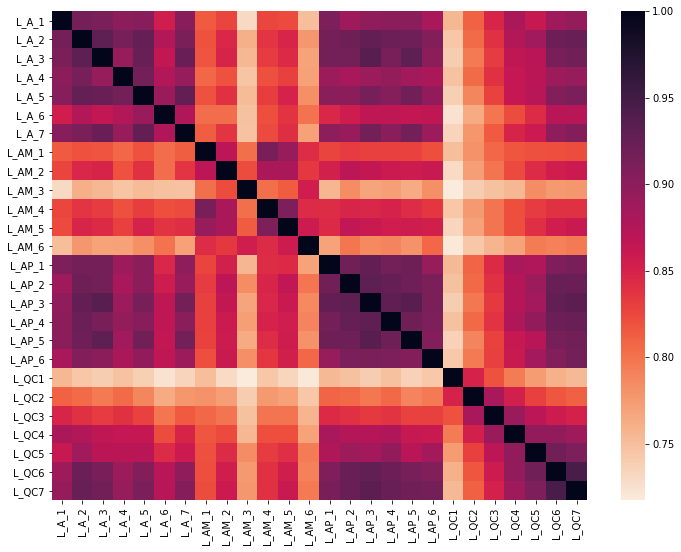

In [11]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, positive mode')
hm = sns.heatmap(dfpos, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Sample similarity, negative mode


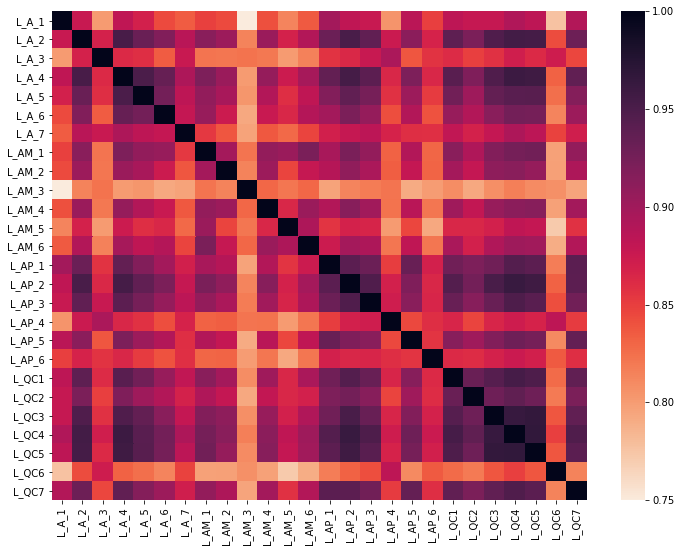

In [12]:
f, ax = plt.subplots(figsize=(12, 9))

print('Sample similarity, negative mode')
hm = sns.heatmap(dfneg, annot=False, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [13]:
dfpos = pd.DataFrame(sim_pos.label_similarity_jaccard,
                     columns=sim_pos.unique_labels,
                     index=sim_pos.unique_labels)

dfneg = pd.DataFrame(sim_neg.label_similarity_jaccard,
                     columns=sim_neg.unique_labels,
                     index=sim_neg.unique_labels)

Label similarity, positive mode


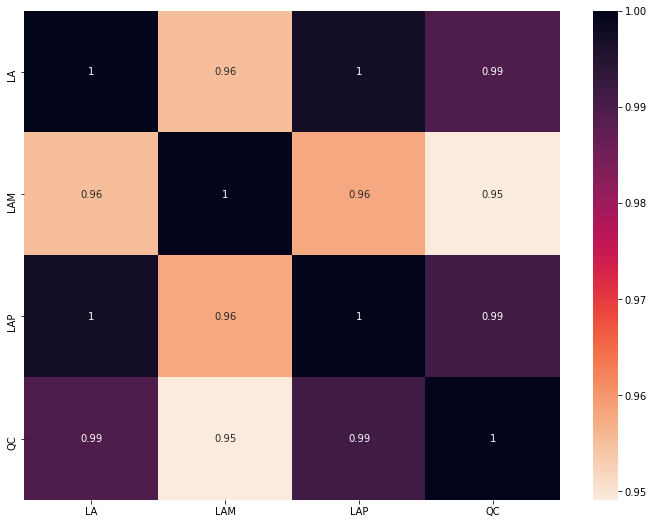

In [14]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, positive mode')
hm = sns.heatmap(dfpos, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Label similarity, negative mode


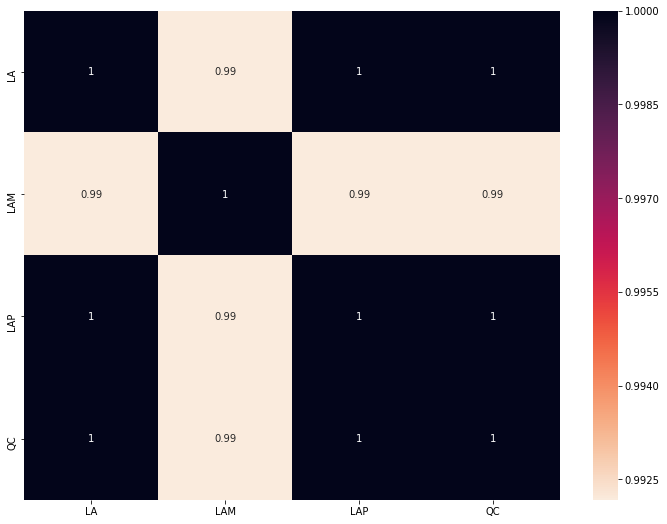

In [15]:
f, ax = plt.subplots(figsize=(12, 9))

print('Label similarity, negative mode')
hm = sns.heatmap(dfneg, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

#### Doing... Experiments with scipy functions...

In [16]:
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier

In [17]:
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    df = df.copy()
    df[df.notnull()] = 1
    df[df.isnull()] = 0
    return df
aligned_01 = df_to_bool(aligned_hp.data)
# confirm it is 0's and 1's
#aligned_01

In [18]:
jdist = dist.pdist(aligned_01.T, metric='jaccard')
print(dist.squareform(jdist))
print('------------------------------------')
sim = mz_similarity(aligned_hp)
jsim = sim.sample_similarity_jaccard
jdist = 1 - jsim
print(jdist)

[[0.         0.08472012 0.0891968  0.1000876  0.09564086 0.14557647
  0.09666884 0.18532986 0.17317597 0.26892558 0.17401643 0.17625668
  0.24876795 0.0897046  0.11120598 0.10168767 0.09875483 0.09814895
  0.11810178 0.2444395  0.18895028 0.15157524 0.11870346 0.13902596
  0.11170213 0.10601536]
 [0.08472012 0.         0.06871376 0.08510178 0.07341227 0.12424893
  0.08839305 0.18007254 0.15258566 0.23856349 0.16311301 0.15139273
  0.22267206 0.08401026 0.07903707 0.07279693 0.07836457 0.08017058
  0.09308284 0.25557239 0.19451641 0.16036113 0.1242236  0.11310286
  0.07759354 0.07551585]
 [0.0891968  0.06871376 0.         0.10642873 0.07619253 0.13517566
  0.07630609 0.18154571 0.15080214 0.24438262 0.16688034 0.15551768
  0.2299659  0.08310071 0.08384894 0.0643915  0.08643815 0.0684902
  0.0991453  0.25997398 0.20383952 0.16731183 0.13313356 0.12956669
  0.08646696 0.08194977]
 [0.1000876  0.08510178 0.10642873 0.         0.08313279 0.12412281
  0.10698785 0.19298246 0.18076676 0.25390

## Wrapping up in a function...

Wolbachia dendogram, Jaccard distance, LCMS


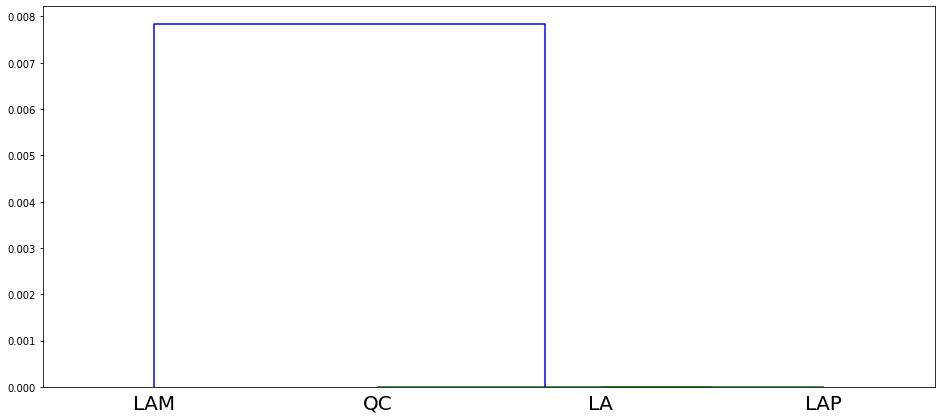

In [19]:
print('Wolbachia dendogram, Jaccard distance, LCMS')
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_neg.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')
fig.savefig('dendo_cultivars_jaccard_negative.pdf')

In [20]:
print(hier.cophenet(Z,jdist)[0])

1.0


Wolbachia dendogram, Jaccard distance, DIMS


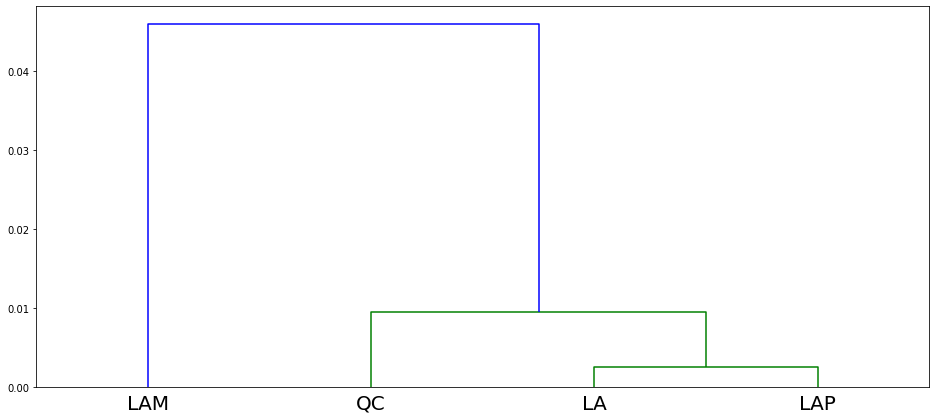

In [21]:
print('Wolbachia dendogram, Jaccard distance, DIMS')
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard)
Z = hier.linkage(jdist, method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z, labels=sim_pos.unique_labels,
                     leaf_font_size=20,
                     above_threshold_color='b')
fig.savefig('dendo_cultivars_jaccard_positive.pdf')

In [22]:
print(hier.cophenet(Z,jdist)[0])

0.9911810040993682


### Other Binary Similarity Analysis Methods

In [23]:
aligned_hp_bin = df_to_bool(aligned_hp.data)
aligned_sp_bin = df_to_bool(aligned_sp.data)

Creating the colours label for all dendrograms (negative and positive have the same labels):

In [24]:
label_colors = {}
colours = cm.get_cmap('nipy_spectral', 8)
col_lbl = colours(range(8))
for i in range(len(col_lbl)):
    label_colors[aligned_sp.labels[3*i]] = col_lbl[i]

Wolbachia dendogram, Binary methods, LCMS


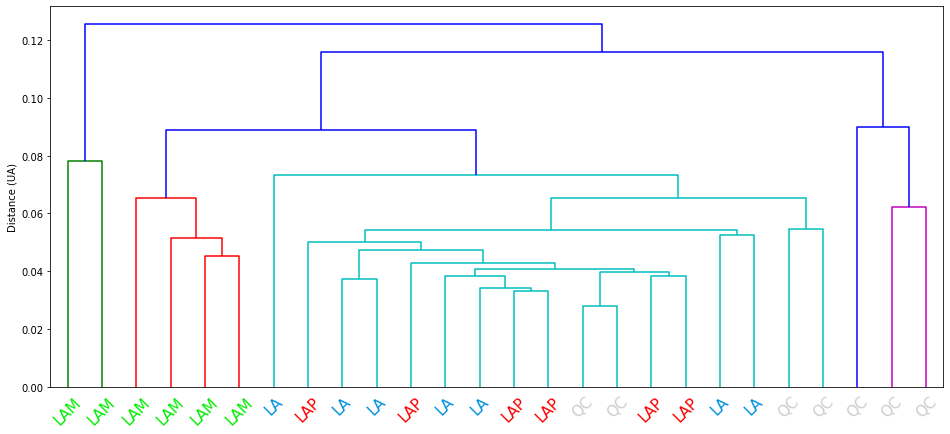

In [25]:
#Apply one of the following:
#dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule
#kulsinski, rusellrao

print('Wolbachia dendogram, Binary methods, LCMS')
Zdice_neg = hier.linkage(aligned_hp_bin.T, metric = 'dice', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_neg, labels=aligned_hp.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Wolbachia dendogram, Binary methods, DIMS


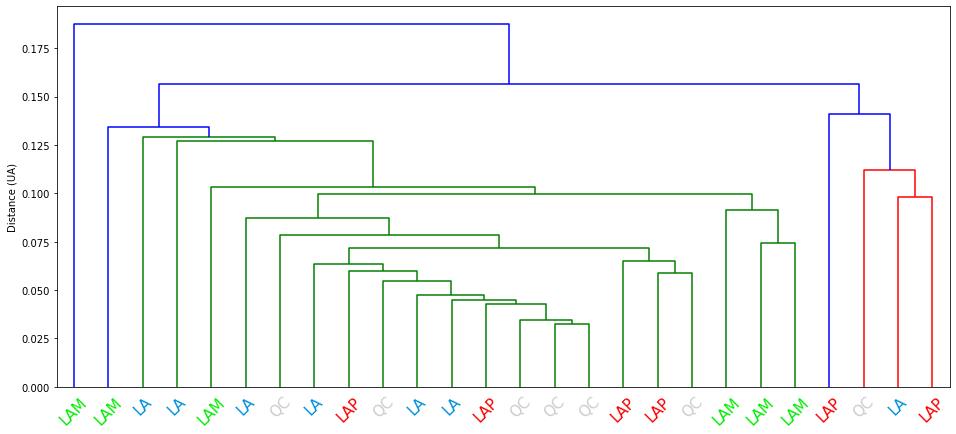

In [26]:
print('Wolbachia dendogram, Binary methods, DIMS')
Zdice_pos = hier.linkage(aligned_sp_bin.T, metric = 'hamming', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zdice_pos, labels=aligned_sp.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

### Non-binary Similarity Analysis

All samples need to have missing value imputation (removing features is optional) with the function NaN_Imputation of scaling.py (replace missing features with half of the minimum intensity of the full dataset).

After that, the rest of the data processing can vary where 3 different processing emthods were applied in different combinations:

##### Normalization by a references feature (Norm_feat from scaling.py) - N;
##### Glog transformation/ log2 transformation (glog from scaling.py) - G;
##### Pareto Scaling (ParetoScal from scaling.py) - P.
Three combinations were used and compared: No treatment (Imp), only Pareto Scaling (P) and glog transformation and Pareto Scaling (NGP).

In [27]:
import scaling as sca
import numpy as np

#### LCMS

Since the state of the data we have is unknown among the different Metabolights datasets (some are known to have performed some kind of normalization, others there isn't any certainties) and since the reference features also are, for the most part, not known, normalization procedures aren't applied here as they were in previous dataset and the "absence of treatment" in the data is also tested since most of these dataset already suffered some kind of treatment.

3 types of processing:

Euc_Imp_pos - Missing Value Imputation.

Euc_P_pos - Missing Value Imputation and Pareto Scaling.

Euc_NGP_pos - Missing Value Imputation, glog transformation and Pareto Scaling.

In [28]:
#Euc_P_neg
Imputated_neg = sca.NaN_Imputation(aligned_hp, 0)
Euc_P_neg = sca.ParetoScal(Imputated_neg)

Wolbachia dendogram, Euclidean distance, LCMS, NaN Imputation


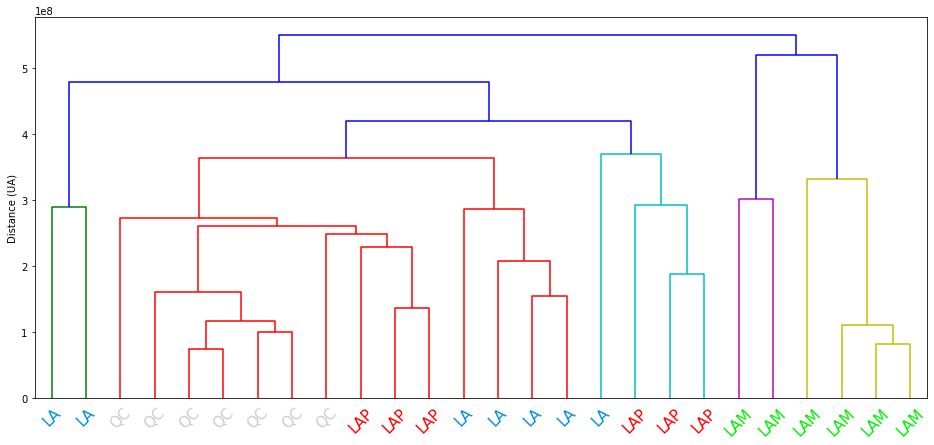

In [29]:
#Measure Euclidean distances
dist_euc_Imp_neg = dist.pdist(Imputated_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Wolbachia dendogram, Euclidean distance, LCMS, NaN Imputation')
Z_euc_Imp_neg = hier.linkage(dist_euc_Imp_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_Imp_neg, labels=Imputated_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Wolbachia dendogram, Euclidean distance, LCMS, NaN Imputation and Pareto Scaling


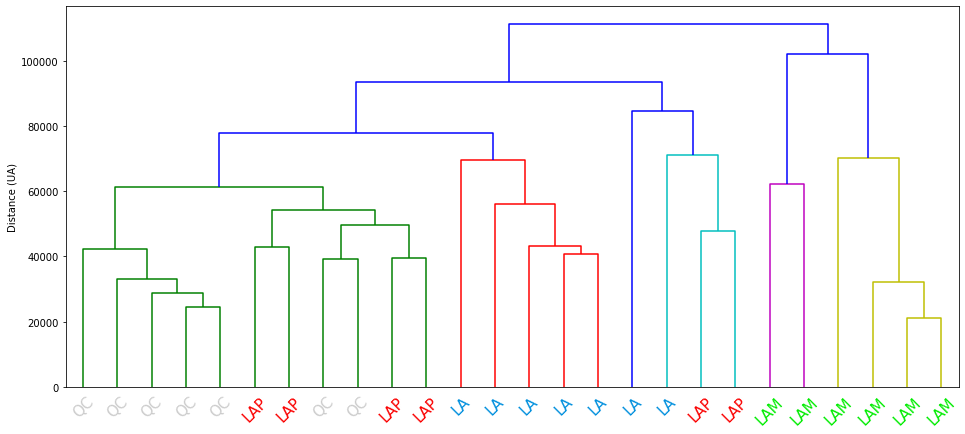

In [30]:
#Measure Euclidean distances
dist_euc_P_neg = dist.pdist(Euc_P_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Wolbachia dendogram, Euclidean distance, LCMS, NaN Imputation and Pareto Scaling')
Z_euc_P_neg = hier.linkage(dist_euc_P_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_P_neg, labels=Euc_P_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [31]:
#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
print(hier.cophenet(Z_euc_P_neg,dist_euc_P_neg)[0]) #method average seems to lead to higher coefficients

0.7941402810153173


In [32]:
#Euc_NGP_neg
glog_neg = sca.glog(Imputated_neg, 0)
Euc_NGP_neg = sca.ParetoScal(glog_neg)

Wolbachia dendogram, Euclidean distance, LCMS, NaN Imputation, Transformed and Pareto Scaling


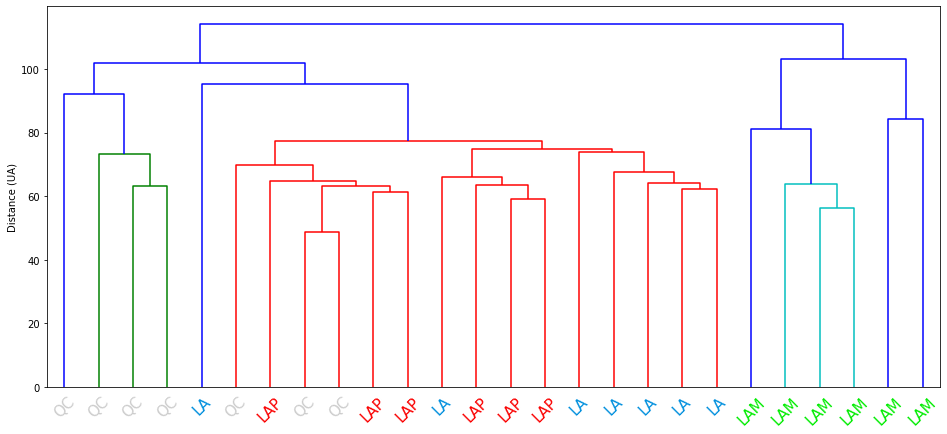

In [33]:
#Measure Euclidean distances
dist_euc_NGP_neg = dist.pdist(Euc_NGP_neg.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Wolbachia dendogram, Euclidean distance, LCMS, NaN Imputation, Transformed and Pareto Scaling')
Z_euc_NGP_neg = hier.linkage(dist_euc_NGP_neg, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NGP_neg, labels=Euc_NGP_neg.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [34]:
print(hier.cophenet(Z_euc_NGP_neg,dist_euc_NGP_neg)[0]) 

0.7929141449250607


#### DIMS

3 types of processing:

Euc_Imp_pos - Missing Value Imputation.

Euc_P_pos - Missing Value Imputation and Pareto Scaling.

Euc_NGP_pos - Missing Value Imputation, glog transformation and Pareto Scaling.

In [35]:
#Euc_P_pos
Imputated_pos = sca.NaN_Imputation(aligned_sp, 0.0000)
Euc_P_pos = sca.ParetoScal(Imputated_pos)

Wolbachia dendogram, Euclidean distance, DIMS, NaN Imputation


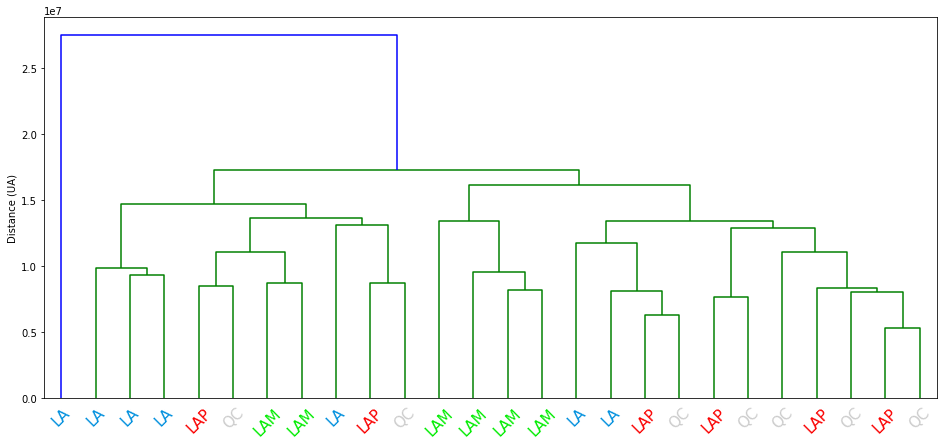

In [36]:
#Measure Euclidean distances
dist_euc_Imp_pos = dist.pdist(Imputated_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Wolbachia dendogram, Euclidean distance, DIMS, NaN Imputation')
Z_euc_Imp_pos = hier.linkage(dist_euc_Imp_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_Imp_pos, labels=Imputated_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Wolbachia dendogram, Euclidean distance, DIMS, NaN Imputation and Pareto Scaling


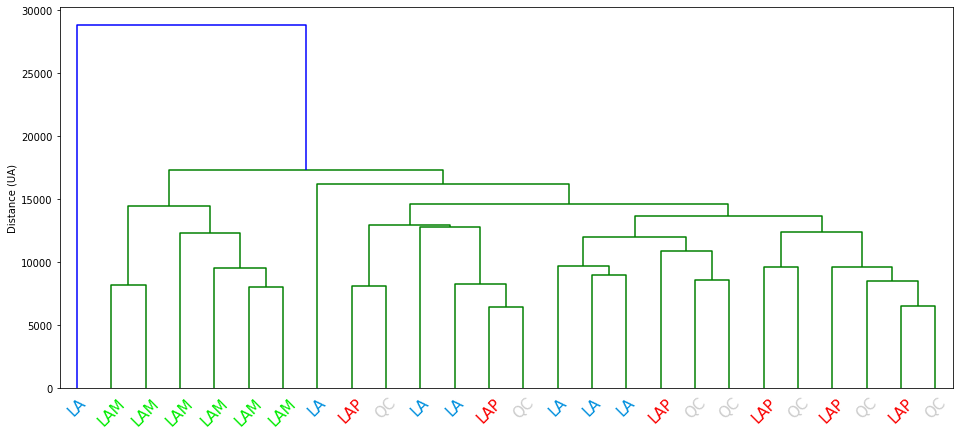

In [37]:
#Measure Euclidean distances
dist_euc_P_pos = dist.pdist(Euc_P_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Wolbachia dendogram, Euclidean distance, DIMS, NaN Imputation and Pareto Scaling')
Z_euc_P_pos = hier.linkage(dist_euc_P_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_P_pos, labels=Euc_P_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [38]:
print(hier.cophenet(Z_euc_P_pos,dist_euc_P_pos)[0])

0.8321472020876851


In [39]:
#Euc_NGP_pos
glog_pos = sca.glog(Imputated_pos, 0)
Euc_NGP_pos = sca.ParetoScal(glog_pos)

Wolbachia dendogram, Euclidean distance, DIMS, NaN Imputation, Transformed and Pareto Scaling


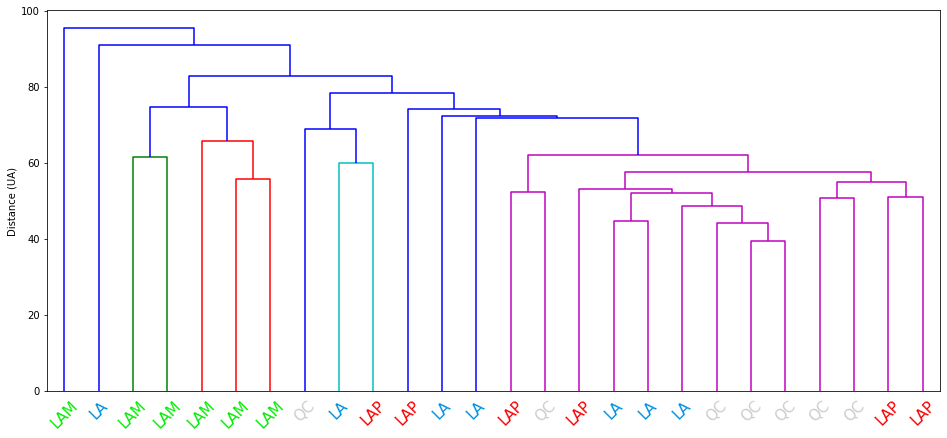

In [40]:
#Measure Euclidean distances
dist_euc_NGP_pos = dist.pdist(Euc_NGP_pos.data.T, metric = 'euclidean')

#Constructing Dendrogram
print('Wolbachia dendogram, Euclidean distance, DIMS, NaN Imputation, Transformed and Pareto Scaling')
Z_euc_NGP_pos = hier.linkage(dist_euc_NGP_pos, method='average') #ward, average, centroid, single, complete, weighted, median
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_euc_NGP_pos, labels=Euc_NGP_pos.labels,
                     leaf_font_size=15,
                     above_threshold_color='b')
#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

In [41]:
print(hier.cophenet(Z_euc_NGP_pos,dist_euc_NGP_pos)[0])

0.8482194380868353


### Comparing Dendrograms

#### Two methods so far: Baker's Gamma Correlation and Cophenetic Correlation Coefficient

#### Examples of procedure with these methods

In [42]:
import numpy as np
import scipy.stats as stats
import multianalysis as ma

#### Baker's method

Use of the mergerank function from multianalysis to create a 'rank' of the iteration number two samples were linked to the same cluster.

In [43]:
euclidean = (Z_euc_Imp_neg, Z_euc_P_neg, Z_euc_NGP_neg, Z_euc_Imp_pos, Z_euc_P_pos, Z_euc_NGP_pos)
dist_euclidean = (dist_euc_Imp_neg, dist_euc_P_neg, dist_euc_NGP_neg, dist_euc_Imp_pos, dist_euc_P_pos, dist_euc_NGP_pos)

#euclidean = (Z_euc_Imp_pos, Z_euc_P_pos, Z_euc_NGP_pos)
#dist_euclidean = (dist_euc_Imp_pos, dist_euc_P_pos, dist_euc_NGP_pos)

K_euc = []
S_euc = []
Coph_euc = []

for i in range(len(euclidean)):
    K_euc.append(ma.mergerank(euclidean[i])) #Mergerank
    S_euc.append(K_euc[i][K_euc[i]!=0]) #Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_euc.append(hier.cophenet(euclidean[i], dist_euclidean[i])) #Matrix of Cophenetic distances

#### Examples

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [44]:
print('Pair of samples\tKendall Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.kendalltau(S_euc[0],S_euc[1])[0], '\t', stats.kendalltau(S_euc[0],S_euc[1])[1])
print('Imp_neg-NGP_neg\t', stats.kendalltau(S_euc[0],S_euc[2])[0], '\t', stats.kendalltau(S_euc[0],S_euc[2])[1])

Pair of samples	Kendall Correlation 	p-value
Imp_neg-P_neg  	 0.8576350561629629 	 1.1369356620580076e-168
Imp_neg-NGP_neg	 0.6141810407849145 	 7.833531632188808e-88


According to the explanation given in the R package dendextend

In [45]:
print('Pair of samples\tSpearman Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.spearmanr(S_euc[0],S_euc[1])[0], '\t', stats.spearmanr(S_euc[0],S_euc[1])[1])
print('Imp_neg-NGP_neg\t', stats.spearmanr(S_euc[0],S_euc[2])[0], '\t', stats.spearmanr(S_euc[0],S_euc[2])[1])

Pair of samples	Spearman Correlation 	p-value
Imp_neg-P_neg  	 0.9312087645317252 	 3.134956787118317e-286
Imp_neg-NGP_neg	 0.7746424885694349 	 4.455572008989268e-131


#### Cophenetic Correlation Coefficient

In [46]:
#Acho que se pode aplicar logo a função np.corrcoef visto os elementos que vêm da função cophenet estão sempre na mesma ordem 
#uns em relação aos outros.

In [47]:
print('Pair of samples\tPearson Correlation \tp-value')
print('Imp_neg-P_neg  \t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[1][1])[1])
print('Imp_neg-NGP_neg\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[0], '\t', stats.pearsonr(Coph_euc[0][1],Coph_euc[2][1])[1])

Pair of samples	Pearson Correlation 	p-value
Imp_neg-P_neg  	 0.9132188287125527 	 5.58305629107286e-128
Imp_neg-NGP_neg	 0.615066718731192 	 3.2993163502446416e-35


### Comparison of dendrograms made with all binary metrics and euclidean distances 

#### Correlations between all pairs using all 3 methods

In [48]:
#9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('jaccard', 'hamming', 'yule')

In [49]:
#Application of all "single" steps needed presented in the examples above with every distance metric.
#Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(aligned_hp_bin.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(aligned_hp_bin.T, metric = binary[i]))) #Cophenetic

In [50]:
#Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(aligned_sp_bin.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(aligned_sp_bin.T, metric = binary[i]))) #Cophenetic

In [51]:
#Creation of a list with all the "rank" values (in order) for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
S = []
S.extend(S_euc)
S.extend(S_neg)
S.extend(S_pos)
#Creation of a list with all the returns from the function cophenetic for the different metrics: 
#Negative Euclideans, Positive Euclideans, Negative Binaries, Positive Binaries
Coph = []
Coph.extend(Coph_euc)
Coph.extend(Coph_neg)
Coph.extend(Coph_pos)

Creation of all dataframes needed to store all correlation coeficients and respective p-values fot all three methods

In [52]:
#Column names and row names for the dataframes
colnames = ['euc_Imp_neg', 'euc_P_neg', 'euc_NGP_neg', 'euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos',
            'jaccard_neg', 'hamming_neg', 'yule_neg', 'jaccard_pos', 'hamming_pos', 'yule_pos']
#colnames = ['euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos','jaccard_pos', 'hamming_pos', 'yule_pos']

In [53]:
df_K = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #K - Kendall (Baker)
df_S = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #S - Spearman (Baker)
df_C = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #C - Cophenetic Correlation
df_K_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of K method
df_S_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of S method
df_C_p = pd.DataFrame(np.zeros((len(S),len(S))), columns = colnames, index = colnames) #p-values of C method

In [54]:
#Calculation of correlation coefficient for each method
for i in range(len(S)):
    for j in range(len(S)):
        df_K.iloc[i,j] = stats.kendalltau(S[i],S[j])[0] #Correlation coefficient
        df_S.iloc[i,j] = stats.spearmanr(S[i],S[j])[0] #Correlation coefficient
        df_C.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[0] #Correlation coefficient
        df_K_p.iloc[i,j] = stats.kendalltau(S[i],S[j])[1] #p-value
        df_S_p.iloc[i,j] = stats.spearmanr(S[i],S[j])[1] #p-value
        df_C_p.iloc[i,j] = stats.pearsonr(Coph[i][1],Coph[j][1])[1] #p-value
        
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,len(S)))* np.nan, columns = colnames, index=[''])
lineV = pd.concat([line.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,6:]], axis = 1)
df_KI = pd.concat([df_K.iloc[:6], line, df_K.iloc[6:]])
df_KI = pd.concat([df_KI.iloc[:,:6], lineV.T, df_KI.iloc[:,6:]], axis = 1)
df_SI = pd.concat([df_S.iloc[:6], line, df_S.iloc[6:]])
df_SI = pd.concat([df_SI.iloc[:,:6], lineV.T, df_SI.iloc[:,6:]], axis = 1)
df_CI = pd.concat([df_C.iloc[:6], line, df_C.iloc[6:]])
df_CI = pd.concat([df_CI.iloc[:,:6], lineV.T, df_CI.iloc[:,6:]], axis = 1)

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


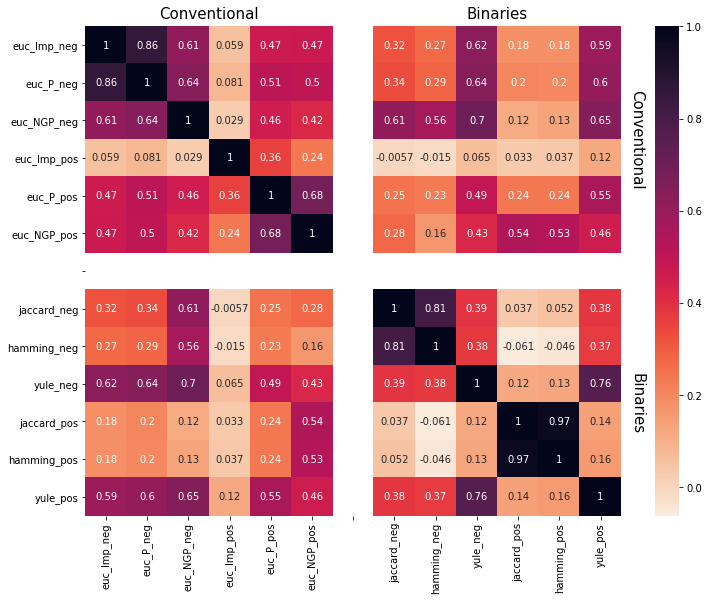

In [55]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


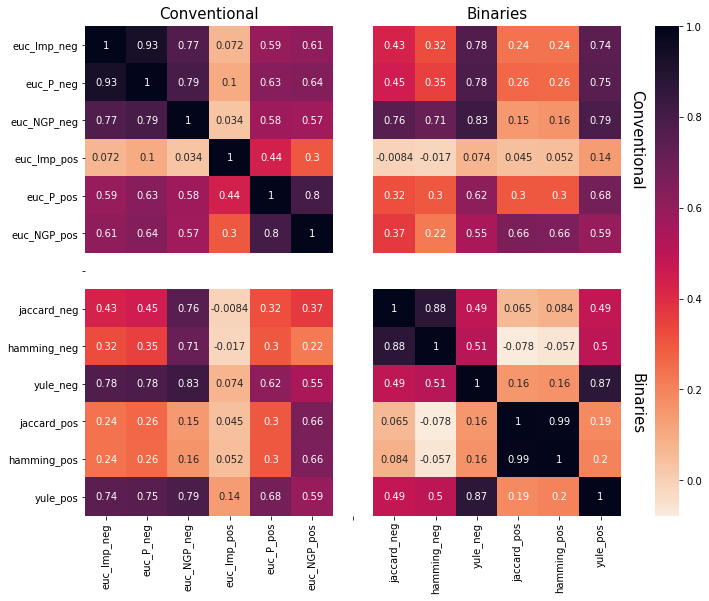

In [56]:
f, ax = plt.subplots(figsize=(12, 9))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode


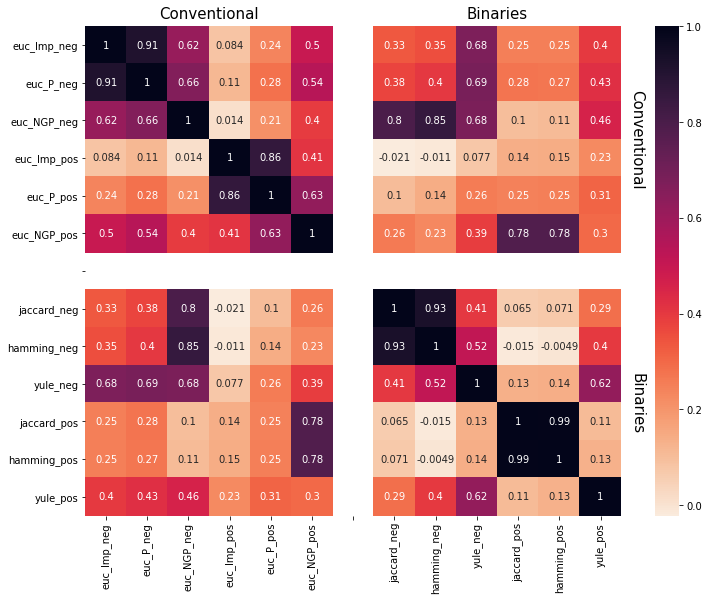

In [57]:
f, ax = plt.subplots(figsize=(12, 9))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 6: Euclidean_DataProcessing_Mode; Last 6: BinaryMetric_Mode')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(3,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(13.2,3,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 15, horizontalalignment='center')
plt.text(13.2,10,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Colours for these labels (groups: euclidean_neg, euclidean_pos, neg_binary, pos_binary)

In [58]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[df_K.columns[3*i]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+1]] = col_lbl2[i]
    label_colors2[df_K.columns[3*i+2]] = col_lbl2[i]
#for i in range(9):
    #label_colors2[df_K.columns[12+i]] = col_lbl2[4]
    #label_colors2[df_K.columns[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


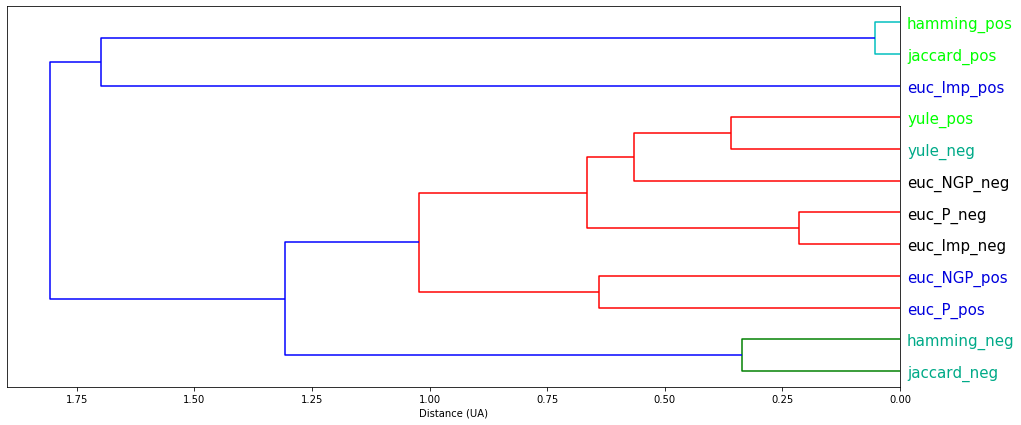

In [59]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_K = hier.linkage(df_K, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=df_K.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


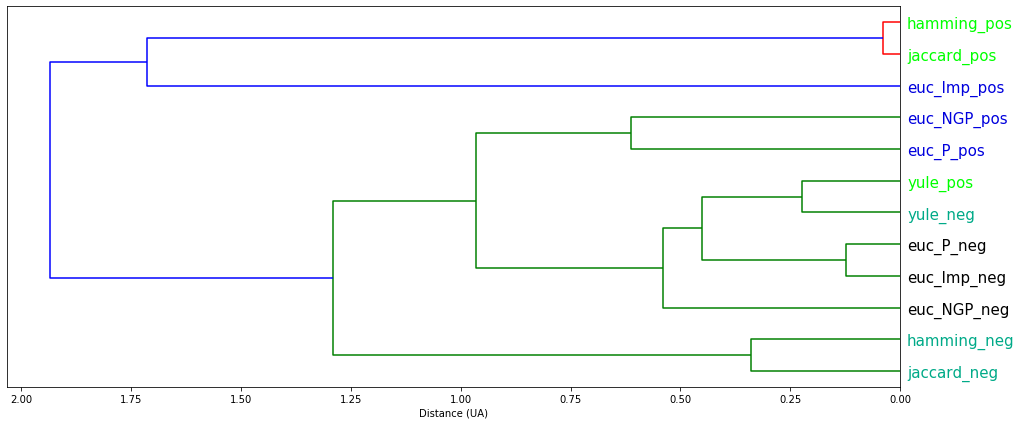

In [60]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_S = hier.linkage(df_S, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=df_S.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode


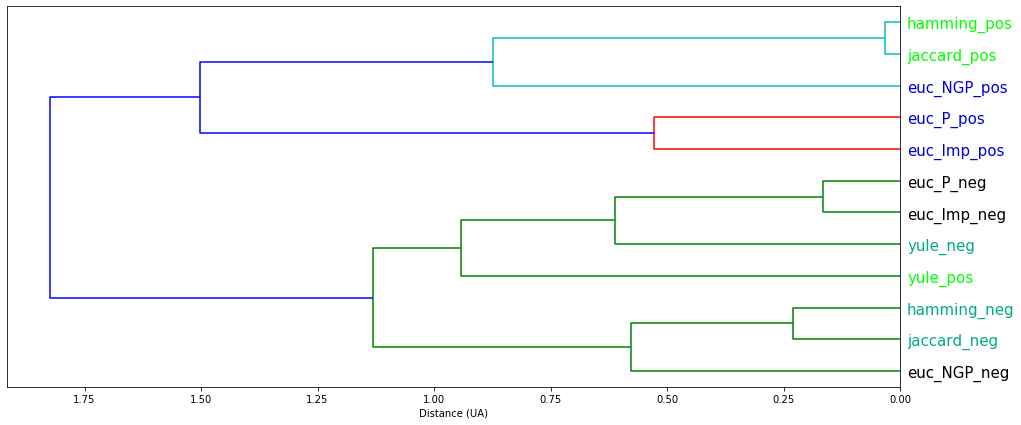

In [61]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: Euclidean_DataProcessing_Mode; or BinaryMetric_Mode')
Z_C = hier.linkage(df_C, metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=df_C.columns,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Distance discrimination of all methods applied (and shown in previous heatmap/dendrogram).

In [62]:
#Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [63]:
disc_average = np.zeros((1,12))
disc_median = np.zeros((1,12))
disc_correct = np.zeros((1,12))
for i in range(len(Z)):
    discrim = sca.dist_discrim(aligned_sp, Z[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = sca.dist_discrim(aligned_sp, Z[i], 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances average']).T, disc_average.iloc[:,6:]], axis = 1)
disc_median = pd.concat([disc_median.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['distances median']).T, disc_median.iloc[:,6:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['correct groupings']).T, disc_correct.iloc[:,6:]], axis = 1)

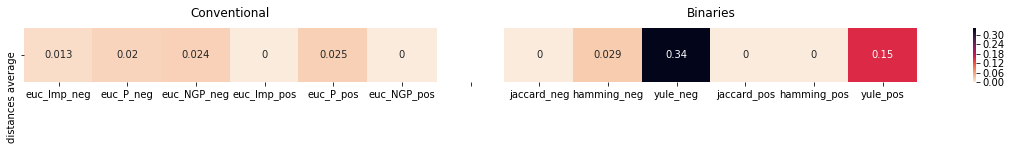

In [64]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

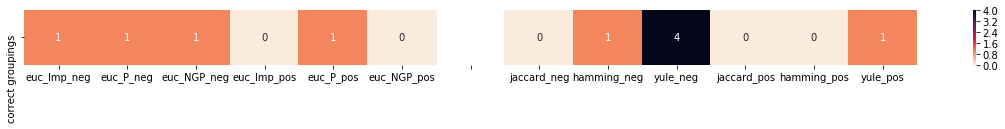

In [65]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

In [66]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### K-means clustering

In [67]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering and how samples are separated 
Use of the module do sci-kit learn - sklearn. Cluster number equal to the amount of varieties. How well can this method separate the varieties. Default parameters except number of clusters.

This example doesn't necessarily mirror the results below (for the case in example) since K-means clustering has an intrinsically random side to it and the clustering is performed again for the case example.

In [68]:
Kmean = skclust.KMeans(n_clusters=4)

In [69]:
a = Kmean.fit(Euc_NGP_pos.data.T)
a = Kmean.fit(aligned_sp_bin.T)

In [70]:
dicto = {}
for i in range(len(a.labels_)):
    if a.labels_[i] in dicto:
        dicto[a.labels_[i]].append(aligned_sp.labels[i])
    else:
        dicto[a.labels_[i]] = [aligned_sp.labels[i]]
dicto

{1: ['LA',
  'LA',
  'LA',
  'LA',
  'LA',
  'LA',
  'LAM',
  'LAP',
  'LAP',
  'LAP',
  'LAP',
  'LAP',
  'QC',
  'QC',
  'QC',
  'QC',
  'QC',
  'QC'],
 0: ['LA', 'LAP', 'QC'],
 3: ['LAM', 'LAM', 'LAM', 'LAM'],
 2: ['LAM']}

### K-means clustering applied to all euclidean methods and the binary matrixes built

To try and get a condensed and more easily digestible version of the results, a method similar to the discrimination distance performed in the hierarchical clustering was made. The same metrics as before are used.

Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero. Therefore, this method is harsher than the original dist_discrim method. The distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. This distance is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean/median of the discrimination distances of all groups is then a measure of the global discrimination distance

Use of the Kmeans_discrim function from multianalysis to calculate discrimination distance.

In [71]:
#aligned_neg2 = df_to_bool(aligned_all_neg2.data)
#aligned_pos2 = df_to_bool(aligned_all_pos2.data)

In [72]:
colnames2 = ['euc_Imp_neg', 'euc_P_neg', 'euc_NGP_neg', 'euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos',
             'aligned_neg', 'aligned_pos']
#colnames2 = ['euc_Imp_pos', 'euc_P_pos', 'euc_NGP_pos', 'aligned_pos']

In [73]:
euclidean = (Imputated_neg, Euc_P_neg, Euc_NGP_neg, Imputated_pos, Euc_P_pos, Euc_NGP_pos)#, 
binaries = (aligned_hp_bin, aligned_sp_bin)

#euclidean = (Imputated_pos, Euc_P_pos, Euc_NGP_pos)#, 
#binaries = (aligned_sp_bin)

In [74]:
from metabolinks import AlignedSpectra

In [75]:
disc_average = np.zeros((1,8))
disc_median = np.zeros((1,8))
disc_correct = np.zeros((1,8))
for i in range(len(euclidean)):
    discrim = ma.Kmeans_discrim(euclidean[i], method = 'average')  #all samples have the same order
    disc_average[0,i] = discrim[0]
    disc_median[0,i] = ma.Kmeans_discrim(euclidean[i], method = 'median')[0] #all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])

discrim = ma.Kmeans_discrim(AlignedSpectra(aligned_sp_bin, labels = aligned_sp.labels), method = 'average')
disc_average[0,6] 
disc_average[0,6] = discrim[0]
disc_median[0,6] = ma.Kmeans_discrim(AlignedSpectra(aligned_sp_bin, labels = aligned_sp.labels), method = 'median')[0] 
correct = np.array(list(discrim[1].values()))
disc_correct[0,6] = len(correct[correct>0])

discrim = ma.Kmeans_discrim(AlignedSpectra(aligned_hp_bin, labels = aligned_sp.labels), method = 'average')
disc_average[0,7] 
disc_average[0,7] = discrim[0]
disc_median[0,7] = ma.Kmeans_discrim(AlignedSpectra(aligned_hp_bin, labels = aligned_hp.labels), method = 'median')[0] 
correct = np.array(list(discrim[1].values()))
disc_correct[0,7] = len(correct[correct>0])

disc_average = pd.DataFrame(disc_average, index = ['distances average'], columns = colnames2)
disc_median = pd.DataFrame(disc_median, index = ['distances median'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct, index = ['correct groupings'], columns = colnames2)


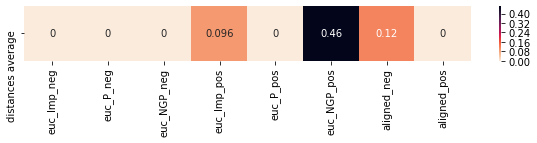

In [76]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

In [77]:
#f, ax = plt.subplots(figsize=(10, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

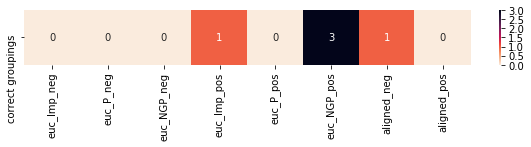

In [78]:
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### RandomForests Attempts - 3-fold cross-validation, n_estimators = 200

This section of the notebook takes some time.

In [79]:
#Creation of "binary" Spectras using the binary matrices built with the function df_to_bool.
binary_neg1 = AlignedSpectra(aligned_hp_bin, labels = aligned_hp.labels)
binary_pos1 = AlignedSpectra(aligned_sp_bin, labels = aligned_sp.labels)

In [80]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {}
values['n_estimators'] = range(10,750,10)
rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv = 4)

In [81]:
param = []
test_score = []
for i in range(len(euclidean)):
    clf.fit(euclidean[i].data.T, euclidean[i].labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])

clf.fit(aligned_hp_bin.T, Euc_P_neg.labels)
param.append(clf.cv_results_['param_n_estimators'])
test_score.append(clf.cv_results_['mean_test_score'])
    
clf.fit(aligned_sp_bin.T, Euc_P_neg.labels)
param.append(clf.cv_results_['param_n_estimators'])
test_score.append(clf.cv_results_['mean_test_score'])


C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-pack

Performance based on number of trees, Negative Mode


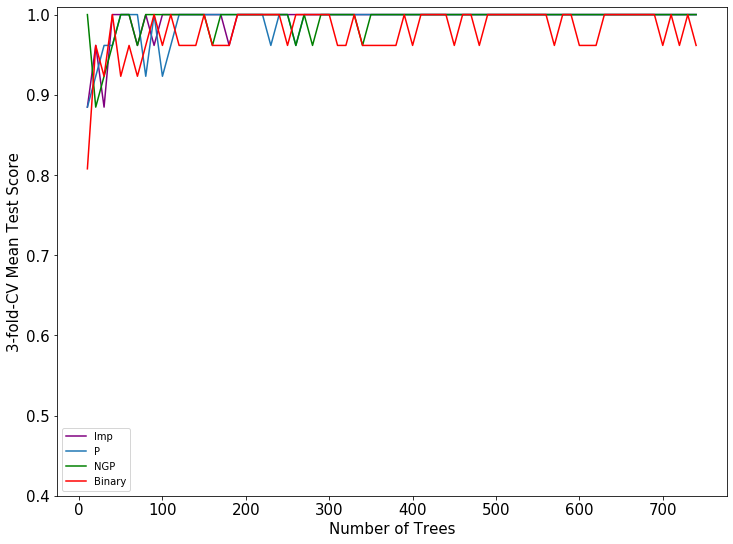

In [82]:
f, ax = plt.subplots(figsize=(12,9))
plt.plot(param[0], test_score[0], color = 'purple')
plt.plot(param[1], test_score[1])
plt.plot(param[2], test_score[2], color = 'green')
plt.plot(param[6], test_score[6], color = 'red')
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
print('Performance based on number of trees, Negative Mode')

Performance based on number of trees, Positive Mode


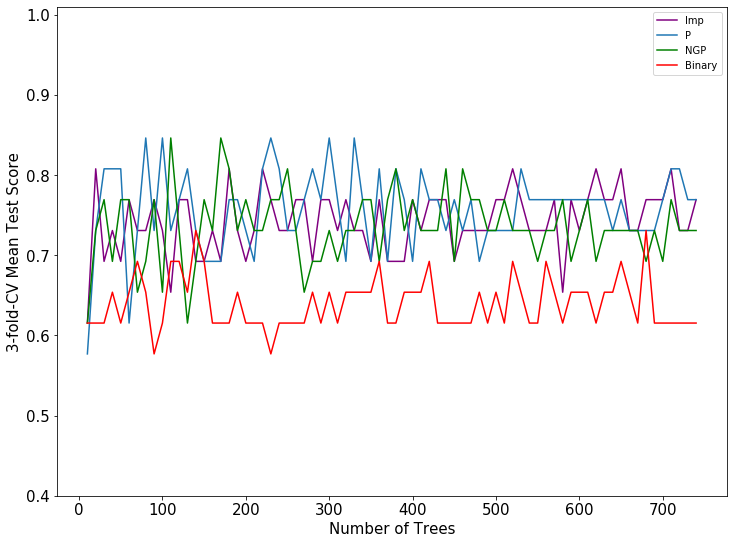

In [83]:
f, ax = plt.subplots(figsize=(12,9))
plt.plot(param[3], test_score[3], color = 'purple')
plt.plot(param[4], test_score[4])
plt.plot(param[5], test_score[5], color = 'green')
plt.plot(param[7], test_score[7], color = 'red')
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
print('Performance based on number of trees, Positive Mode')

### Performance of N, NP and NGP data treatments (alignment 1-6)

See performance of all 3 treatments and absence of them in non-binary data to see which performs the best using method nº1 (simple application of random forests), see below.

In [84]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [85]:
Teste = {}
Teste_std = {}
Teste_feat = {}
N1_D = ma.simple_RF(Imputated_neg, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['Imp_neg'] = np.mean(N1_D[0])
Teste_std['Imp_neg'] = np.std(N1_D[0])
Teste_feat['Imp_neg'] = N1_D[1]
N1_D = ma.simple_RF(Euc_P_neg, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['P_neg'] = np.mean(N1_D[0])
Teste_std['P_neg'] = np.std(N1_D[0])
Teste_feat['P_neg'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NGP_neg, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['NGP_neg'] = np.mean(N1_D[0])
Teste_std['NGP_neg'] = np.std(N1_D[0])
Teste_feat['NGP_neg'] = N1_D[1]

BN1_D = ma.simple_RF(binary_neg1, n_fold = 4)#, iter_num = 100)#
Teste['bin_neg'] = np.mean(BN1_D[0])
Teste_std['bin_neg'] = np.std(BN1_D[0])
Teste_feat['bin_neg'] = BN1_D[1]

In [86]:
N1_D = ma.simple_RF(Imputated_pos, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['Imp_pos'] = np.mean(N1_D[0])
Teste_std['Imp_pos'] = np.std(N1_D[0])
Teste_feat['Imp_pos'] = N1_D[1]
N1_D = ma.simple_RF(Euc_P_pos, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['P_pos'] = np.mean(N1_D[0])
Teste_std['P_pos'] = np.std(N1_D[0])
Teste_feat['P_pos'] = N1_D[1]
N1_D = ma.simple_RF(Euc_NGP_pos, n_fold = 4)#, iter_num = 100)#, n_trees = 500)
Teste['NGP_pos'] = np.mean(N1_D[0])
Teste_std['NGP_pos'] = np.std(N1_D[0])
Teste_feat['NGP_pos'] = N1_D[1]

BN1_D = ma.simple_RF(binary_pos1, n_fold = 4)#, iter_num = 100)#
Teste['bin_pos'] = np.mean(BN1_D[0])
Teste_std['bin_pos'] = np.std(BN1_D[0])
Teste_feat['bin_pos'] = BN1_D[1]

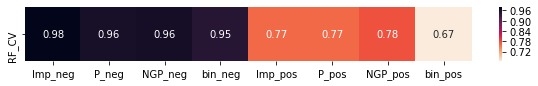

In [87]:
Teste_H = pd.DataFrame(list(Teste.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])

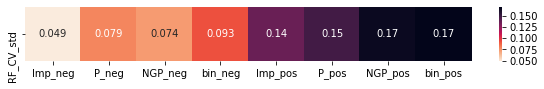

In [88]:
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

Accuracy plot with errors bars corresponding to the 95% confidence interval and accurcy and standard deviation tables

In [89]:
Teste_H = pd.DataFrame(list(Teste.values()), index = Teste.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
Teste_ic = Teste_std_H / (100**0.5)*1.96

In [90]:
#sns.set_context('notebook')

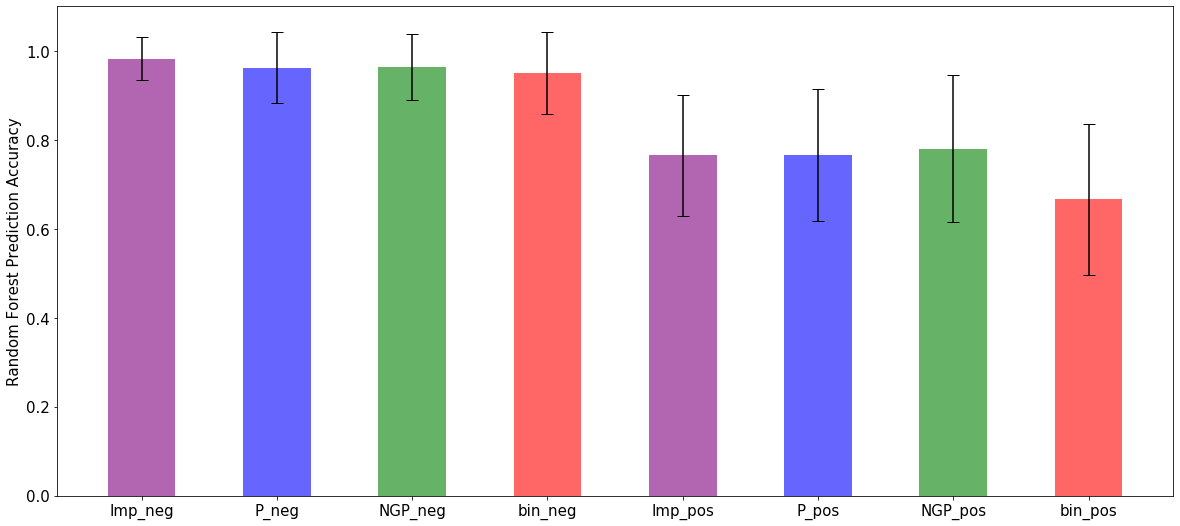

In [91]:
f, ax = plt.subplots(figsize=(20, 9))
#sns.set_context('talk')
color = ['purple','blue','green','red']
plt.bar(height = Teste_H.T['Accuracy'], x = Teste_H.columns, width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns, y = Teste_H.T['Accuracy'], yerr = Teste_std_H.iloc[0,:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1.10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Attempt/Method nº1 - Direct

### Simple application of random forests

The random forest classification is iterated iter_num times to make sure more combinations of training and test samples are used. Then, an average of the results are obtained. 

N-fold Cross-Validation is used as an internal validation system evaluating the performance of the model based on its score/prediction accuracy - the number of folds used will be the one that seems most appropriate in each case. For balanced datasets n_fold = number of replicates in each group if the number of replicates is under 10.

Besides the n-fold cross-validation score, the order of the average of most important features across the random forests (with each iteration and group in cross-validation having the same weight) is extracted from the forests "built".

Application of the function simple_RF from multianalysis.py.

### Characteristics of the features seen as important in the different alignments, data treatments and modes (negative and positive)

We take the 2% most important features in each case and calculate the average number of samples those features appear (samples_m), the average number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). We also see how many times the importance of the most importante feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('more').

A scatter plot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

In [92]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature and calculating
#% explained by these features (more)
ev = []
magni = []
more = []
for j in Teste_feat:#['neg2-1_direct']:
    if j.endswith('neg'):
        #continue
        Spectra = aligned_hp
    elif j.endswith('pos'):
        Spectra = aligned_sp
    ratio = []
    nsamples = []
    n_groups = []
    number = round(0.02*len(Spectra))
    magni.append(Teste_feat[j][0][1]/(1/len(Spectra)))
    a = 0
    for i in range(number): 
        a = a + Teste_feat[j][i][1]*100 
        ngroups = {}
        line = Spectra.data.loc[Teste_feat[j][i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    more.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [93]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)


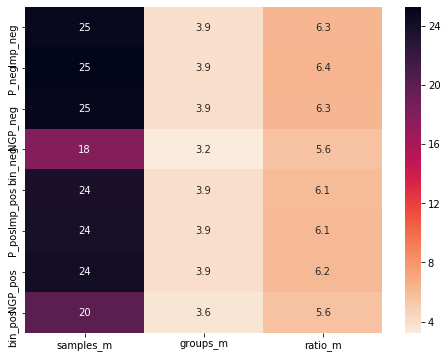

In [94]:
f, ax = plt.subplots(figsize=(8, 6))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

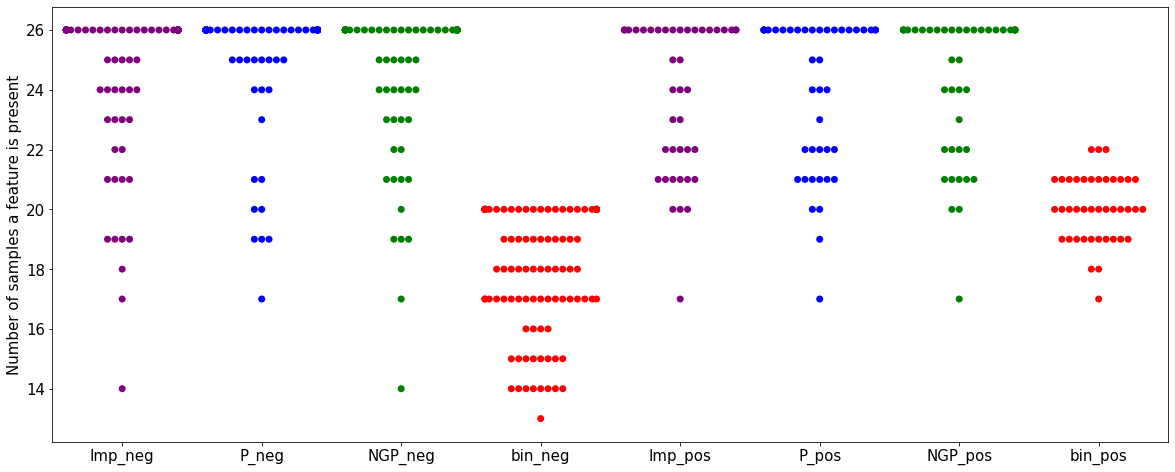

In [95]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:8], size = 7, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [96]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', more)

Magnitude of most important feature: [6.8002959005628725, 6.145247654726635, 6.706380226108857, 34.19482239574062, 12.387586578965434, 11.397966059982082, 11.36558404887121, 26.202496636968498]
% of model explained by the 2% most important features [8.253052379933422, 8.105352469850644, 8.02983144918133, 30.23895053986105, 14.707521101187005, 14.71250590638852, 14.636596773862514, 25.622419126058386]


### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is random forests or pls-da found a significant class structure in the data. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 150 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

In [97]:
CV = {}
PMs = {}
pvalue = {}

In [98]:
permuta = ma.permutation_RF(Imputated_neg, iter_num = 150, n_fold = 6)
CV['Imp_neg'] = permuta[0]
PMs['Imp_neg'] = permuta[1]
pvalue['Imp_neg'] = permuta[2]

permuta = ma.permutation_RF(Euc_P_neg, iter_num = 150, n_fold = 6)
CV['P_neg'] = permuta[0]
PMs['P_neg'] = permuta[1]
pvalue['P_neg'] = permuta[2]

In [99]:
permuta = ma.permutation_RF(Euc_NGP_neg, iter_num = 150, n_fold = 6)
CV['NGP_neg'] = permuta[0]
PMs['NGP_neg'] = permuta[1]
pvalue['NGP_neg'] = permuta[2]

permuta = ma.permutation_RF(binary_neg1, iter_num = 150, n_fold = 6)
CV['bin_neg'] = permuta[0]
PMs['bin_neg'] = permuta[1]
pvalue['bin_neg'] = permuta[2]

In [100]:
permuta = ma.permutation_RF(Imputated_pos, iter_num = 150, n_fold = 6)
CV['Imp_pos'] = permuta[0]
PMs['Imp_pos'] = permuta[1]
pvalue['Imp_pos'] = permuta[2]

permuta = ma.permutation_RF(Euc_P_pos, iter_num = 150, n_fold = 6)
CV['P_pos'] = permuta[0]
PMs['P_pos'] = permuta[1]
pvalue['P_pos'] = permuta[2]

In [101]:
permuta = ma.permutation_RF(Euc_NGP_pos, iter_num = 150, n_fold = 6)
CV['NGP_pos'] = permuta[0]
PMs['NGP_pos'] = permuta[1]
pvalue['NGP_pos'] = permuta[2]

permuta = ma.permutation_RF(binary_pos1, iter_num = 150, n_fold = 6)
CV['bin_pos'] = permuta[0]
PMs['bin_pos'] = permuta[1]
pvalue['bin_pos'] = permuta[2]

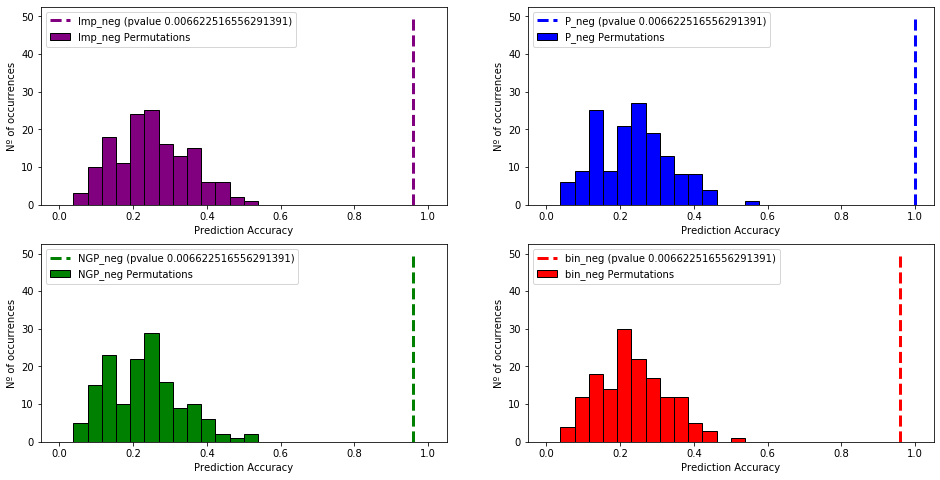

In [102]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

for i in range(len(Names)):
    quadrant[i].hist(PMs[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

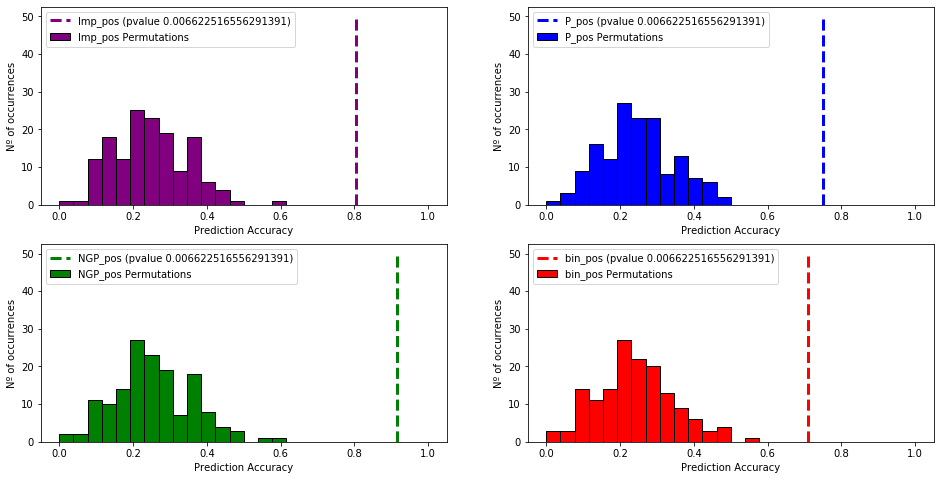

In [103]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_pos', 'P_pos', 'NGP_pos', 'bin_pos']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

### PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong).

In [104]:
matrix = pd.get_dummies(aligned_sp.labels)
matrix = matrix[["LA","LAM","LAP","QC"]]

## Alignment 1-6

### Search for the best number of components to use

Strategy: Perform PLS-DA with different number of components and observe the score (both given directly by the method and the r2 score) and the mean-squared error (MSE) of the models built with 3-fold cross-validation (3 was chosen since it is the max for our dataset - 3 replicates in each group, having an added bonus of still maintaining a balanced dataset). Then plot the different results obtained and see at which point (number of components) the score and the MSE stops start approaching a "stable value".

The maximum number of components tested was 50 (which was enough for the objective established above).

Warnings are due to the type of scoring that will be changed in the next version of scikit learn.

Function optim_PLS in multianalysis.py - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp.

In [105]:
%%capture
#PLS applied in the negative dataset.
Imp_neg_PLS = ma.optim_PLS(Imputated_neg, matrix, max_comp = 30, n_fold = 6)
P_neg_PLS = ma.optim_PLS(Euc_P_neg, matrix, max_comp = 30, n_fold = 6)
NGP_neg_PLS = ma.optim_PLS(Euc_NGP_neg, matrix, max_comp = 30, n_fold = 6)
bin_neg_PLS = ma.optim_PLS(binary_neg1, matrix, max_comp = 30, n_fold = 6)

#PLS applied in the positive dataset.
Imp_pos_PLS = ma.optim_PLS(Imputated_pos, matrix, max_comp = 30, n_fold = 6)
P_pos_PLS = ma.optim_PLS(Euc_P_pos, matrix, max_comp = 30, n_fold = 6)
NGP_pos_PLS = ma.optim_PLS(Euc_NGP_pos, matrix, max_comp = 30, n_fold = 6)
bin_pos_PLS = ma.optim_PLS(binary_pos1, matrix, max_comp = 30, n_fold = 6)

Performance based on number of components, Negative Mode


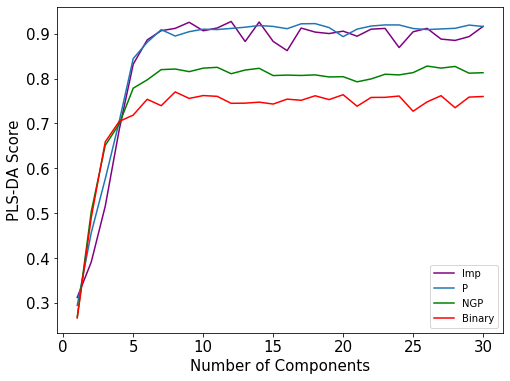

In [106]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_neg_PLS[0], color = 'purple')
plt.plot(range(1,31),P_neg_PLS[0])
plt.plot(range(1,31),NGP_neg_PLS[0], color = 'green')
plt.plot(range(1,31),bin_neg_PLS[0], color = 'red')
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components, Negative Mode')

Performance based on number of components, Positive Mode


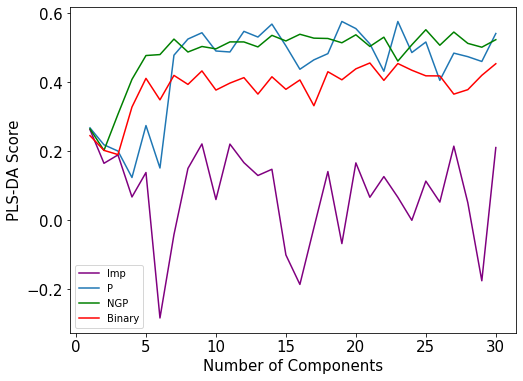

In [107]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31),Imp_pos_PLS[0], color = 'purple')
plt.plot(range(1,31),P_pos_PLS[0])
plt.plot(range(1,31),NGP_pos_PLS[0], color = 'green')
plt.plot(range(1,31),bin_pos_PLS[0], color = 'red')
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.legend(('Imp', 'P', 'NGP', 'Binary'))
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of components, Positive Mode')

### Application of PLS-DA

The number of components where the evaluating metrics stopped getting considerably better was the numebr of components used in each case. 

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule.

Two metrics to evaluate the results were evaluated. First the score of the model as seen before but more importantly the second one is the accuracy of the model based on the decision rule stated above. All samples are tested once in k different groups as k-fold cross-validation.

In [108]:
PLS_accu = {}
PLS_score = {}
PLS_weights = {}
PLS_RegCoef = {}

In [109]:
%%capture
Imp_neg_PLS = ma.model_PLSDA(Imputated_neg, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['Imp_neg'] = Imp_neg_PLS[0]
PLS_score['Imp_neg'] = Imp_neg_PLS[1]
PLS_weights['Imp_neg'] = Imp_neg_PLS[3]
PLS_RegCoef['Imp_neg'] = Imp_neg_PLS[4]

P_neg_PLS = ma.model_PLSDA(Euc_P_neg, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['P_neg'] = P_neg_PLS[0]
PLS_score['P_neg'] = P_neg_PLS[1]
PLS_weights['P_neg'] = P_neg_PLS[3]
PLS_RegCoef['P_neg'] = P_neg_PLS[4]

NGP_neg_PLS = ma.model_PLSDA(Euc_NGP_neg, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['NGP_neg'] = NGP_neg_PLS[0]
PLS_score['NGP_neg'] = NGP_neg_PLS[1]
PLS_weights['NGP_neg'] = NGP_neg_PLS[3]
PLS_RegCoef['NGP_neg'] = NGP_neg_PLS[4]

bin_neg_PLS = ma.model_PLSDA(binary_neg1, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['bin_neg'] = bin_neg_PLS[0]
PLS_score['bin_neg'] = bin_neg_PLS[1]
PLS_weights['bin_neg'] = bin_neg_PLS[3]
PLS_RegCoef['bin_neg'] = bin_neg_PLS[4]

In [110]:
%%capture
Imp_pos_PLS = ma.model_PLSDA(Imputated_pos, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['Imp_pos'] = Imp_pos_PLS[0]
PLS_score['Imp_pos'] = Imp_pos_PLS[1]
PLS_weights['Imp_pos'] = Imp_pos_PLS[3]
PLS_RegCoef['Imp_pos'] = Imp_pos_PLS[4]

P_pos_PLS = ma.model_PLSDA(Euc_P_pos, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['P_pos'] = P_pos_PLS[0]
PLS_score['P_pos'] = P_pos_PLS[1]
PLS_weights['P_pos'] = P_pos_PLS[3]
PLS_RegCoef['P_pos'] = P_pos_PLS[4]

NGP_pos_PLS = ma.model_PLSDA(Euc_NGP_pos, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['NGP_pos'] = NGP_pos_PLS[0]
PLS_score['NGP_pos'] = NGP_pos_PLS[1]
PLS_weights['NGP_pos'] = NGP_pos_PLS[3]
PLS_RegCoef['NGP_pos'] = NGP_pos_PLS[4]

bin_pos_PLS = ma.model_PLSDA(binary_pos1, matrix, n_comp = 10, iter_num = 100, n_fold = 6)
PLS_accu['bin_pos'] = bin_pos_PLS[0]
PLS_score['bin_pos'] = bin_pos_PLS[1]
PLS_weights['bin_pos'] = bin_pos_PLS[3]
PLS_RegCoef['bin_pos'] = bin_pos_PLS[4]

Accuracy based on the dataset


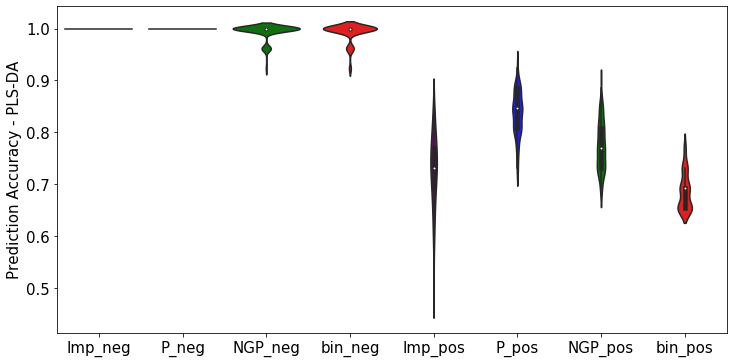

In [111]:
f, ax = plt.subplots(figsize=(12,6))
colors = ['purple','blue','green','red']
sns.violinplot(data=pd.DataFrame.from_dict(PLS_accu), palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
print('Accuracy based on the dataset')

Performance score based on the dataset


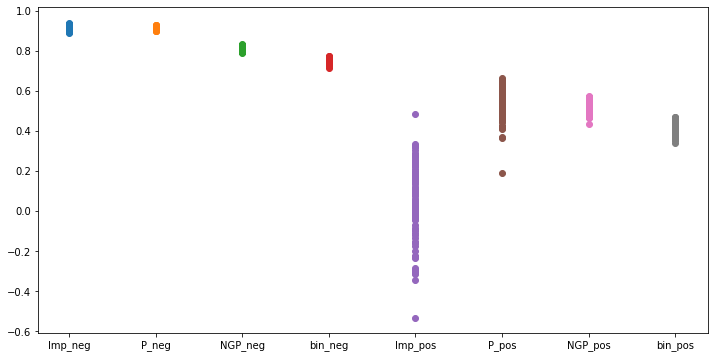

In [112]:
f, ax = plt.subplots(figsize=(12,6))
plt.scatter(['Imp_neg']*len(PLS_score['Imp_neg']), PLS_score['Imp_neg'])
plt.scatter(['P_neg']*len(PLS_score['P_neg']), PLS_score['P_neg'])
plt.scatter(['NGP_neg']*len(PLS_score['NGP_neg']), PLS_score['NGP_neg'])
plt.scatter(['bin_neg']*len(PLS_score['bin_neg']), PLS_score['bin_neg'])
plt.scatter(['Imp_pos']*len(PLS_score['Imp_pos']), PLS_score['Imp_pos'])
plt.scatter(['P_pos']*len(PLS_score['P_pos']), PLS_score['P_pos'])
plt.scatter(['NGP_pos']*len(PLS_score['NGP_pos']), PLS_score['NGP_pos'])
plt.scatter(['bin_pos']*len(PLS_score['bin_pos']), PLS_score['bin_pos'])
##plt.ylabel('PLS-DA Model Score')
print('Performance score based on the dataset')

In [113]:
Accuracy = {}
Accuracy['Imp_neg'] = np.mean(PLS_accu['Imp_neg'])
Accuracy['P_neg'] = np.mean(PLS_accu['P_neg'])
Accuracy['NGP_neg'] = np.mean(PLS_accu['NGP_neg'])
Accuracy['bin_neg'] = np.mean(PLS_accu['bin_neg'])
Accuracy['Imp_pos'] = np.mean(PLS_accu['Imp_pos'])
Accuracy['P_pos'] = np.mean(PLS_accu['P_pos'])
Accuracy['NGP_pos'] = np.mean(PLS_accu['NGP_pos'])
Accuracy['bin_pos'] = np.mean(PLS_accu['bin_pos'])

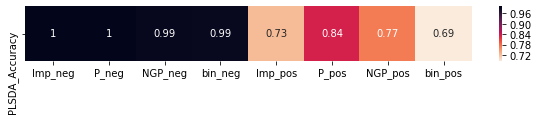

In [114]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

In [115]:
Score = {}
Score['Imp_neg'] = np.mean(PLS_score['Imp_neg'])
Score['P_neg'] = np.mean(PLS_score['P_neg'])
Score['NGP_neg'] = np.mean(PLS_score['NGP_neg'])
Score['bin_neg'] = np.mean(PLS_score['bin_neg'])
Score['Imp_pos'] = np.mean(PLS_score['Imp_pos'])
Score['P_pos'] = np.mean(PLS_score['P_pos'])
Score['NGP_pos'] = np.mean(PLS_score['NGP_pos'])
Score['bin_pos'] = np.mean(PLS_score['bin_pos'])

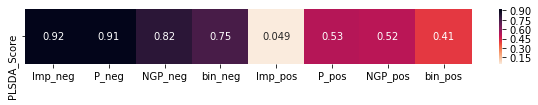

In [116]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
f, ax = plt.subplots(figsize=(10, 1))
hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [117]:
Accuracy_std = {}
Accuracy_std['Imp_neg'] = np.std(PLS_accu['Imp_neg'])
Accuracy_std['P_neg'] = np.std(PLS_accu['P_neg'])
Accuracy_std['NGP_neg'] = np.std(PLS_accu['NGP_neg'])
Accuracy_std['bin_neg'] = np.std(PLS_accu['bin_neg'])
Accuracy_std['Imp_pos'] = np.std(PLS_accu['Imp_pos'])
Accuracy_std['P_pos'] = np.std(PLS_accu['P_pos'])
Accuracy_std['NGP_pos'] = np.std(PLS_accu['NGP_pos'])
Accuracy_std['bin_pos'] = np.std(PLS_accu['bin_pos'])

In [118]:
Score_std = {}
Score_std['Imp_neg'] = np.std(PLS_score['Imp_neg'])
Score_std['P_neg'] = np.std(PLS_score['P_neg'])
Score_std['NGP_neg'] = np.std(PLS_score['NGP_neg'])
Score_std['bin_neg'] = np.std(PLS_score['bin_neg'])
Score_std['Imp_pos'] = np.std(PLS_score['Imp_pos'])
Score_std['P_pos'] = np.std(PLS_score['P_pos'])
Score_std['NGP_pos'] = np.std(PLS_score['NGP_pos'])
Score_std['bin_pos'] = np.std(PLS_score['bin_pos'])

In [119]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())
Accuracy_H.T

,Accuracy,SD
Imp_neg,1.000000,0.000000
P_neg,1.000000,0.000000
NGP_neg,0.994615,0.014412
bin_neg,0.993077,0.017524
Imp_pos,0.726538,0.071727
P_pos,0.835385,0.042161
NGP_pos,0.773462,0.045474
bin_pos,0.686538,0.035408


In [120]:
Score_H = pd.DataFrame(list(Score.values()), index = Score.keys(), columns  = ['Score']).T
Score_H.loc['SD'] = list(Score_std.values())
Score_H.T

,Score,SD
Imp_neg,0.916829,0.010418
P_neg,0.914417,0.006847
NGP_neg,0.815761,0.009084
bin_neg,0.751263,0.009443
Imp_pos,0.049435,0.185126
P_pos,0.528056,0.073339
NGP_pos,0.517949,0.024850
bin_pos,0.409614,0.028199


### Characteristics of the most important features

The characteristics of the most important features for each of the methods is done by the same process as applied in the random forests section of the notebook.

In [121]:
#Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
Imp_feat = (PLS_weights, PLS_RegCoef)
ev = []
magni = []
index = []
for m in Imp_feat:
    for j in m:
        if j.endswith('neg'):
            Spectra = aligned_hp
        elif j.endswith('pos'):
            Spectra = aligned_sp
        index.append(j)
        ratio = []
        nsamples = []
        n_groups = []
        number = round(0.02*len(Spectra))
        total_m = 0
        for i in range(len(m[j])):
            total_m = total_m + m[j][i][1]
        magni.append(m[j][0][1]/(total_m/len(Spectra)))
        for i in range(number): 
            ngroups = {}
            line = Spectra.data.loc[m[j][i][2],:].notnull()
            nsamples.append(line.sum())
            for n in range(len(line)):
                if line[n] == True:
                    ngroups[Spectra.labels[n]] = 1
            n_groups.append(sum(list((ngroups.values()))))
            ratio.append(nsamples[-1]/n_groups[-1])
        df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
        df['nsamples'] = nsamples
        df['n_groups'] = n_groups
        df['ratio']  = ratio
        ev.append(df)

In [122]:
#Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.mean(ev[i].iloc[:,0]))
    groups_m.append(np.mean(ev[i].iloc[:,1]))
    ratio_m.append(np.mean(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:8], line, df.iloc[8:]])

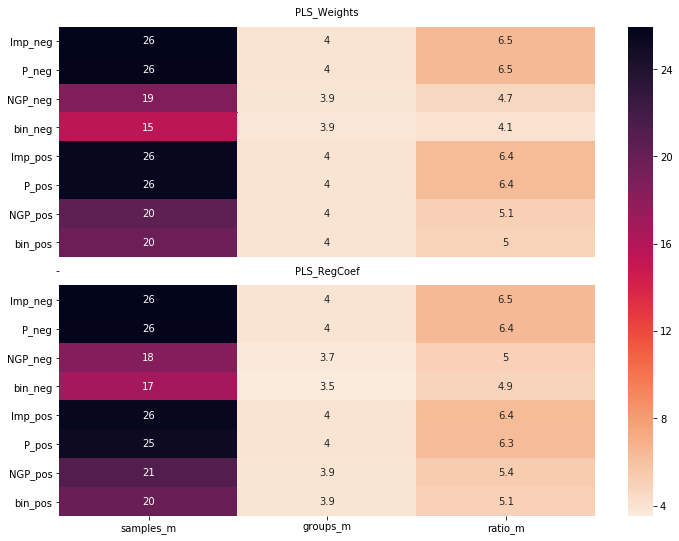

In [123]:
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'PLS_Weights',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,8.5,'PLS_RegCoef',horizontalalignment='center', verticalalignment='center')
plt.show()

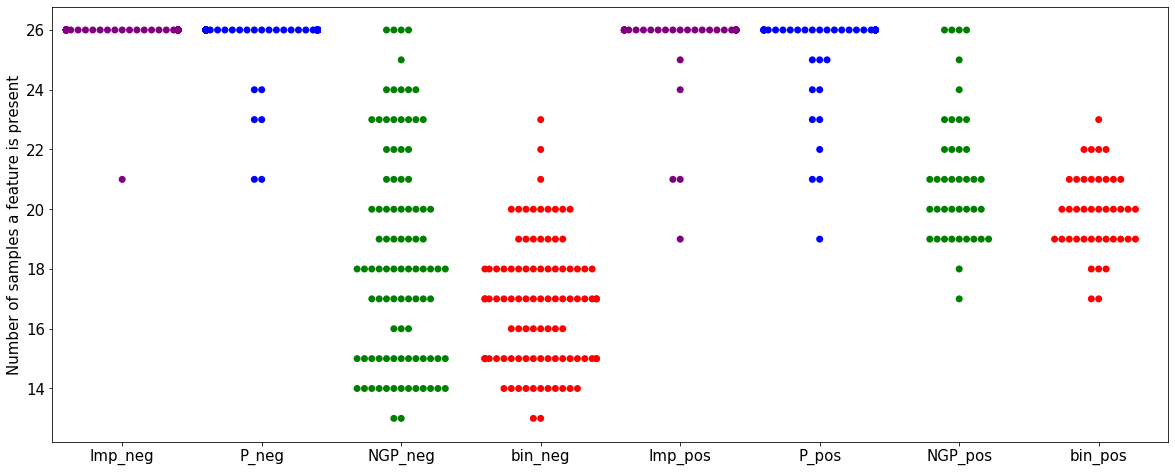

In [124]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[8:], size = 7, palette = ['purple','blue','green','red']*2)
ax.set(xticklabels = [list(PLS_weights.keys())[i][0:13] for i in range(len(PLS_weights.keys()))][:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [125]:
print('Magnitude of most important features for each case:')
print(magni)

Magnitude of most important features for each case:
[87.69962135525854, 25.324159556553692, 2.9324455894790864, 3.8375016068340595, 34.81183647488942, 11.225544417591495, 2.911284045971416, 4.279590283550508, 97.86847870429678, 21.793365762334272, 5.18267178011469, 9.756023023099855, 40.081628216769595, 11.434607611875018, 5.16526660271511, 9.083515508566899]


### Model with the full dataset and sample representation on the two most important Components/Latent Variables

NGP data treatment for the negative mode

In [126]:
from sklearn.cross_decomposition import PLSRegression

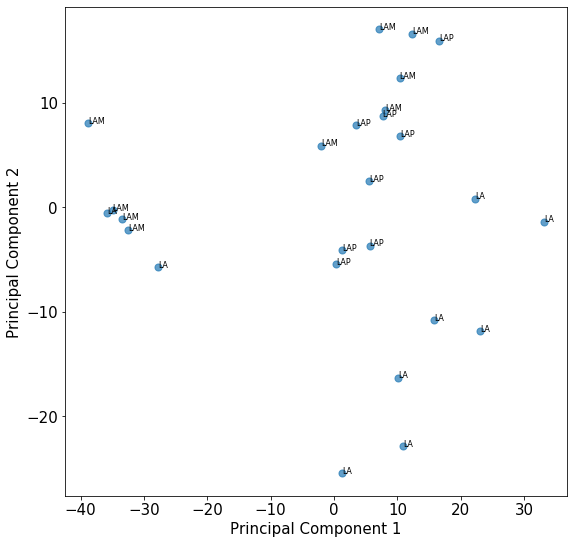

In [127]:
plsda = PLSRegression(n_components = 4)
#Fitting the model and getting the X_scores
plsda.fit(X=Euc_NGP_pos.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 4)
col_lbl = colours(range(4))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, figsize=(9,9))#, c = col_lbl)
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%9 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

Binary processed data for the negative mode

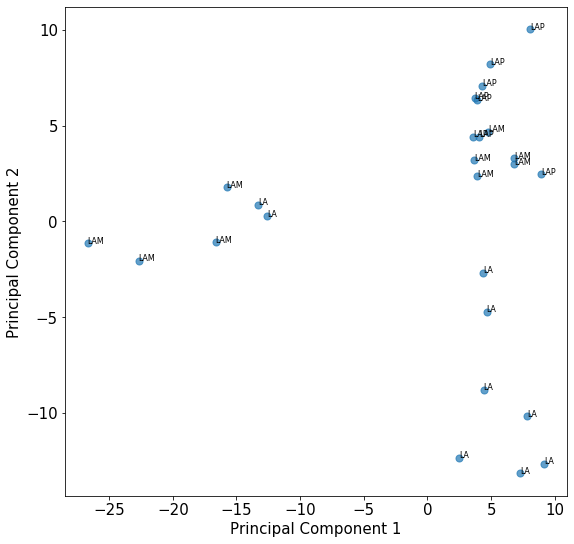

In [128]:
plsda = PLSRegression(n_components = 10)
#Fitting the model and getting the X_scores
plsda.fit(X=binary_pos1.data.T,Y=matrix)
LV_score = pd.DataFrame(plsda.x_scores_)

#Preparing colours to separate different groups
colours = cm.get_cmap('nipy_spectral', 4)
col_lbl = colours(range(4))
col_lbl = list(col_lbl)
for i in range(len(col_lbl)):
    a = 3*i
    col_lbl.insert(a+1,col_lbl[a])
    col_lbl.insert(a+2,col_lbl[a])

    #Scatter plot
ax = LV_score.iloc[:,0:2].plot(x=0, y=1, kind='scatter', s=50, alpha=0.7, figsize=(9,9))#, c = col_lbl)
ax.set_xlabel(xlabel = 'Principal Component 1', size = 15)
ax.set_ylabel(ylabel = 'Principal Component 2', size = 15)
ax.tick_params(axis='both', which='major', labelsize = 15)
#Labeling each point
i = -1
for n, x in enumerate(LV_score.values): 
    if n%9 == 0:
        i = i + 1
        label = Spectra.unique_labels()[i]
                #label = LV_score.index.values[n]
    ax.text(x[0],x[1],label, fontsize = 8)

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

In [129]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [130]:
permuta = ma.permutation_PLSDA(Imputated_neg, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['Imp_neg'] = permuta[0]
PMs_PLS['Imp_neg'] = permuta[1]
pvalue_PLS['Imp_neg'] = permuta[2]

permuta = ma.permutation_PLSDA(Euc_P_neg, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['P_neg'] = permuta[0]
PMs_PLS['P_neg'] = permuta[1]
pvalue_PLS['P_neg'] = permuta[2]

In [131]:
permuta = ma.permutation_PLSDA(Euc_NGP_neg, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['NGP_neg'] = permuta[0]
PMs_PLS['NGP_neg'] = permuta[1]
pvalue_PLS['NGP_neg'] = permuta[2]

permuta = ma.permutation_PLSDA(binary_neg1, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['bin_neg'] = permuta[0]
PMs_PLS['bin_neg'] = permuta[1]
pvalue_PLS['bin_neg'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [132]:
permuta = ma.permutation_PLSDA(Imputated_pos, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['Imp_pos'] = permuta[0]
PMs_PLS['Imp_pos'] = permuta[1]
pvalue_PLS['Imp_pos'] = permuta[2]

permuta = ma.permutation_PLSDA(Euc_P_pos, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['P_pos'] = permuta[0]
PMs_PLS['P_pos'] = permuta[1]
pvalue_PLS['P_pos'] = permuta[2]

C:\Users\francisco\Anaconda3\envs\tese\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


In [133]:
permuta = ma.permutation_PLSDA(Euc_NGP_pos, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['NGP_pos'] = permuta[0]
PMs_PLS['NGP_pos'] = permuta[1]
pvalue_PLS['NGP_pos'] = permuta[2]

permuta = ma.permutation_PLSDA(binary_pos1, n_comp = 8, iter_num = 150, n_fold = 6)
CV_PLS['bin_pos'] = permuta[0]
PMs_PLS['bin_pos'] = permuta[1]
pvalue_PLS['bin_pos'] = permuta[2]

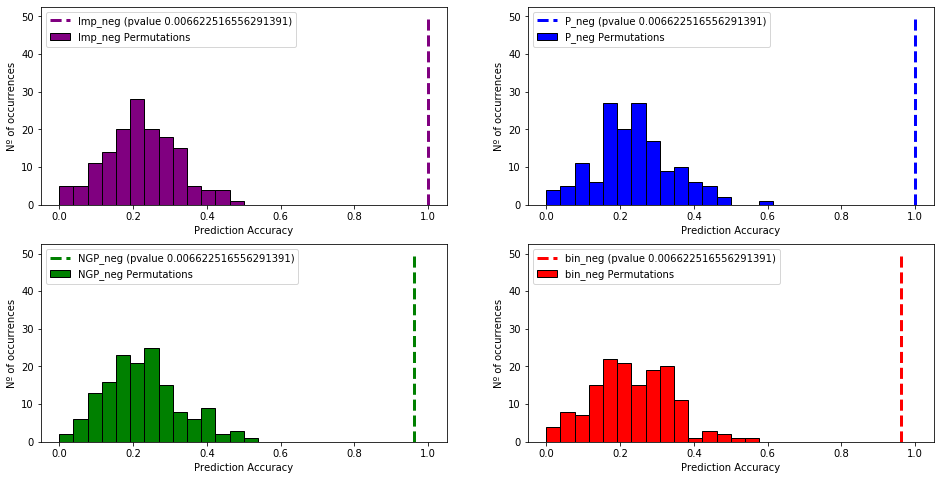

In [134]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['Imp_neg', 'P_neg', 'NGP_neg', 'bin_neg']
color = ['purple','blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

for i in range(len(Names)):
    quadrant[i].hist(PMs_PLS[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()

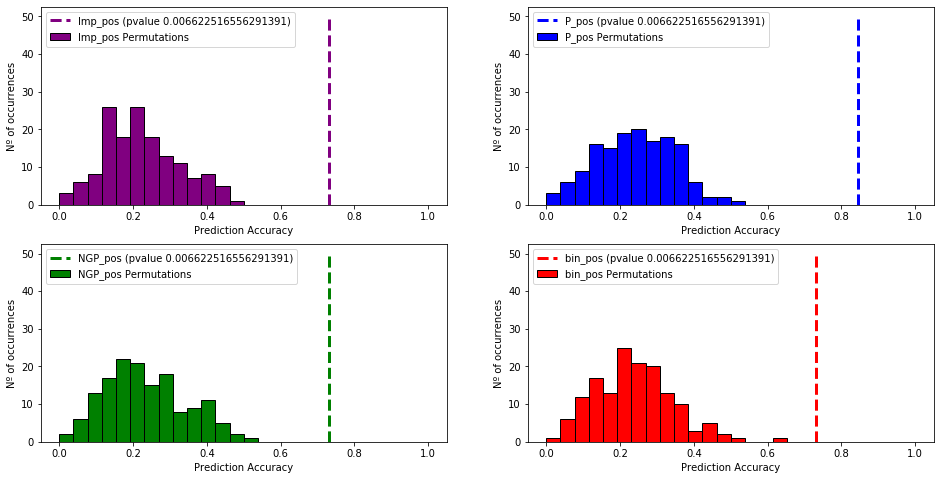

In [135]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['Imp_pos', 'P_pos', 'NGP_pos', 'bin_pos']
color = ['purple', 'blue', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
for i in range(len(Names)):
    quadrant[i].hist(PMs_PLS[Names[i]], len(Euc_NGP_neg.labels), range = (0,1.0001), label = Names[i] + ' Permutations',
             edgecolor='black', color = color[i])#, alpha = 0.3)
    
    quadrant[i].plot(2 * [CV_PLS[Names[i]]], ylim, '--g', linewidth=3, color = color[i], #alpha = 0.5,
             label=Names[i] +
             ' (pvalue %s)' % pvalue_PLS[Names[i]])
    quadrant[i].set(xlabel = 'Prediction Accuracy',ylabel = 'Nº of occurrences')
    quadrant[i].legend()